# 2024S2 DATA2001  Assignment 3 
##  Forecasting: QLD Unemployment 

This analysis focuses on time series data to **forecast future unemployment rates**, offering insights into the trends and potential trajectory of unemployment in Queensland over the coming months. These forecasts provide valuable information **for government officials and economists**, helping them assess labor market conditions and guide decisions related to fiscal and monetary policies. Unemployment is a key economic indicator, reflecting the health of the economy and the well-being of the labor force, making such forecasts essential for shaping policy decisions.

# Table of Content
1. [Data Preparation](#1.-Data-Preparation)
2. [Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
3. [Seasonal Trend Residual Decomposition](#3.-STR-Decomposition)
4. [Timeseries Models](#4.-Timeseries-Models)
5. [Pure Forcasters](#5.-Pure-Forcasters)
6. [Using Side Data](#6.-Using-Side-Data)

# 1. Data Preparation
- Compile all the data for the period 2011-2023 into one series using the “pandas”
library and set up an index for the entire dataset in an appropriate way for
timeseries analysis.

In [154]:
import pandas as pd

# Set File Path 
file1_path = '640101.xlsx'
file2_path = '6202006.xlsx'
file3_path = 'f01d.xlsx'

# Load data，skip rows until SeriesID
inflation = pd.read_excel(file1_path, sheet_name='Data1', skiprows=9) 
unemployment = pd.read_excel(file2_path, sheet_name='Data1', skiprows=9)
interest_rate = pd.read_excel(file3_path, sheet_name='Data', skiprows=10)

# Select specific columns
inflation = inflation[["Series ID","A2325846C"]]
unemployment = unemployment[["Series ID","A84423620T"]]
interest_rate = interest_rate[["Series ID","FIRMMCRTD"]]

# Rename columns
inflation.rename(columns={'Series ID':'Datetime','A2325846C':'Inflation_Rate'}, inplace=True)
unemployment.rename(columns={'Series ID':'Datetime','A84423620T':'Unemployment_Rate'}, inplace=True)
interest_rate.rename(columns={'Series ID':'Datetime','FIRMMCRTD':'Interest_Rate'}, inplace=True)

# Transfer to datetime type
inflation['Datetime'] = pd.to_datetime(inflation['Datetime'])
unemployment['Datetime'] = pd.to_datetime(unemployment['Datetime'])
interest_rate['Datetime'] = pd.to_datetime(interest_rate['Datetime'])

# Set 'Datetime' index
inflation.set_index('Datetime', inplace=True)
unemployment.set_index('Datetime', inplace=True)
interest_rate.set_index('Datetime', inplace=True)

# Select 2011-2023 data
inflation = inflation['2011':'2023']
unemployment = unemployment['2011':'2023']
interest_rate = interest_rate['2011':'2023']

# Turn into DataFrame
inflation_df = pd.DataFrame(inflation)
unemployment_df = pd.DataFrame(unemployment)
interest_rate_df = pd.DataFrame(interest_rate)

- The RBA interest rate data has a different resolution to the unemployment and
inflation data. Explain and briefly justify the adjust to the resolution of the RBA data
that I use.

Inflation rate is provided on quarterly schedules. The trend of the price level is typically represented by the inflation rate. Typically, it is a long-term trend variable that does not significantly change across the quarter's several months. As a result, the first month of every quarter can accurately reflect the state of inflation during that quarter.

The unemployment rate is given each month. The average unemployment rate can more accurately reflect the employment market conditions of the entire quarter, decrease the impact of anomalous fluctuations in a single month, and is more representative. The unemployment rate typically fluctuates a certain amount each month due to seasonal and short-term economic fluctuations.

Data on rates of interest is given every day. As a tool for policy, central banks (like the RBA) establish interest rates, typically holding them steady until the next change. Although the RBA's interest rate statistics may fluctuate daily, interest rates are a short-term instrument that typically holds steady over time. By treating it quarterly, unnecessary short-term fluctuates can be avoided. As a result, the interest rate at the start of the quarter can typically be utilized for forecasting the majority of the quarter.

The data includes a different resolution. Aggregating the data into quarterly frequencies is more consistent with the nature of these data and avoids irrational interpolation of inflation and unemployment rates, which can lead to misleading conclusions and extraneous noise. It is the most reasonable way to merge the data into quarterly data. In addition to ensuring consistency across different indicators, it also makes analysis easier and more accurately represents the macroeconomy's long-term trend.  

In [155]:
# Down-sampling
interest_rate_quarterly = interest_rate_df.resample('QE').first()
unemployment_quarterly = unemployment_df.resample('QE').mean()
inflation_quarterly = inflation.resample('QE').first()

# Merge
merged_df = inflation_df.join(unemployment_quarterly, how='outer').join(interest_rate_quarterly, how='outer')

# Turn to month
merged_df.index = merged_df.index.to_period('M')

# Deal with every first month data in a QE
def combine_quarterly_data(df):
    combined_rows = []  # Used to store processed data for each quarter

    # Group by year and quarter, using `PeriodIndex` directly
    for _, group in df.groupby(df.index):
        # Create a new blank row to store data for each quarter
        combined_row = {}

        # Get the first and last row of each quarter
        first_row = group.iloc[0]  # First month in the quarter
        last_row = group.iloc[-1]  # Last month in the quarter

        # Merge data: keep the Inflation Rate of the first month and the other Rates of the last month
        combined_row['Inflation_Rate'] = first_row['Inflation_Rate'] if pd.notna(first_row['Inflation_Rate']) else last_row['Inflation_Rate']
        combined_row['Unemployment_Rate'] = last_row['Unemployment_Rate'] if pd.notna(last_row['Unemployment_Rate']) else first_row['Unemployment_Rate']
        combined_row['Interest_Rate'] = last_row['Interest_Rate'] if pd.notna(last_row['Interest_Rate']) else first_row['Interest_Rate']

        # Create a quarterly time index (using the first month of the quarter as the timestamp)
        combined_row['Datetime'] = first_row.name

        # Add the processed quarterly data to the list
        combined_rows.append(combined_row)

    # Convert all processed quarterly data back to DataFrame
    combined_df = pd.DataFrame(combined_rows)

    # Set 'Datetime' as index
    combined_df.set_index('Datetime', inplace=True)

    return combined_df
    
# Run the merge function
df = combine_quarterly_data(merged_df)

df.index = df.index.to_timestamp()

print(df.index)

# Output the merged DataFrame
df

DatetimeIndex(['2011-03-01', '2011-06-01', '2011-09-01', '2011-12-01',
               '2012-03-01', '2012-06-01', '2012-09-01', '2012-12-01',
               '2013-03-01', '2013-06-01', '2013-09-01', '2013-12-01',
               '2014-03-01', '2014-06-01', '2014-09-01', '2014-12-01',
               '2015-03-01', '2015-06-01', '2015-09-01', '2015-12-01',
               '2016-03-01', '2016-06-01', '2016-09-01', '2016-12-01',
               '2017-03-01', '2017-06-01', '2017-09-01', '2017-12-01',
               '2018-03-01', '2018-06-01', '2018-09-01', '2018-12-01',
               '2019-03-01', '2019-06-01', '2019-09-01', '2019-12-01',
               '2020-03-01', '2020-06-01', '2020-09-01', '2020-12-01',
               '2021-03-01', '2021-06-01', '2021-09-01', '2021-12-01',
               '2022-03-01', '2022-06-01', '2022-09-01', '2022-12-01',
               '2023-03-01', '2023-06-01', '2023-09-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Datetime', freq='QS-DEC')


,Inflation_Rate,Unemployment_Rate,Interest_Rate
Datetime,,,
2011-03-01,98.3,6.229757,4.75
2011-06-01,99.2,5.191075,4.75
2011-09-01,99.8,5.364334,4.75
2011-12-01,99.8,5.106490,4.75
2012-03-01,99.9,6.240249,4.25
2012-06-01,100.4,5.313804,4.25
2012-09-01,101.8,5.760147,3.50
2012-12-01,102.0,5.730412,3.50
2013-03-01,102.4,6.402738,3.00


In [156]:
df.isna().sum()

Inflation_Rate       0
Unemployment_Rate    0
Interest_Rate        0
dtype: int64

There is no null value. Data Preparation has finished.

---

# 2. Exploratory Data Analysis
- Visualise the data timeseries (appropriate uncertainty and correlation)
- comment on the patterns 

In [157]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

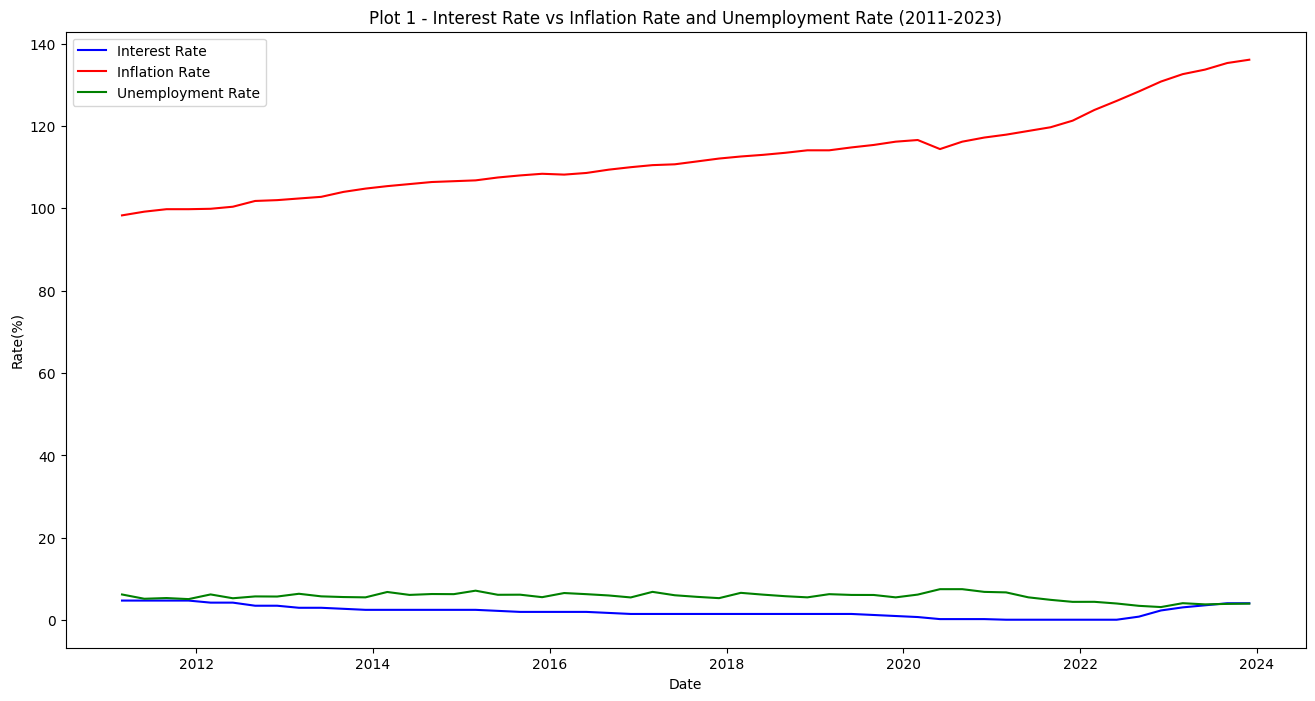

In [158]:
# Lineplot to view 2011-2023 Interest Rate vs Inflation Rate and Unemployment Rate
plt.figure(figsize=(16, 8))
plt.plot(df['Interest_Rate'], label='Interest Rate', color='blue')
plt.plot(df['Inflation_Rate'], label='Inflation Rate', color='red')
plt.plot(df['Unemployment_Rate'], label='Unemployment Rate', color='green')

plt.title('Plot 1 - Interest Rate vs Inflation Rate and Unemployment Rate (2011-2023)')
plt.xlabel('Date')
plt.ylabel('Rate(%)')
plt.legend()
plt.show()

### Observation from Time series Plot1:  
**Cyclical Patterns:**
- Interest rates are usually policy tools that adjust in a cyclical manner based on economic conditions (such as rising or falling inflation). In the years around 2016, interest rates were relatively low, and around 2022, there were some fluctuations in interest rates, which may be related to adjustments in the central bank's policy cycle.
- From 2012 to 2020, when interest rates were lowered, inflation increased over time.
- The unemployment rate does not have a significant cyclical trend, and the data is relatively scattered. This may be because the unemployment rate is affected by a variety of factors, and the adjustment cycle may be long, and there may be a certain lag effect (more details will be explored later).
- These cycles are usually related to economic cycles (such as booms, recessions, etc.), but are not short-term seasonal cycles, but longer economic cycles.

**Step or Regime Changes：**
- After 2020, interest rates dropped sharply in a short period of time. It may be that the central bank implemented easing policies after the epidemic began.
- In 2022 and 2023, there will be several clear jumps in interest rate increases or decreases. These jumps are usually policy adjustments by the central bank in response to inflation and the economic environment. These changes form a "ladder."

It can be seen from Plot1 that macroeconomic indicators such as interest rates, inflation rates, and unemployment rates are more affected by policies and economic cycles, and there is no obvious seasonal pattern.

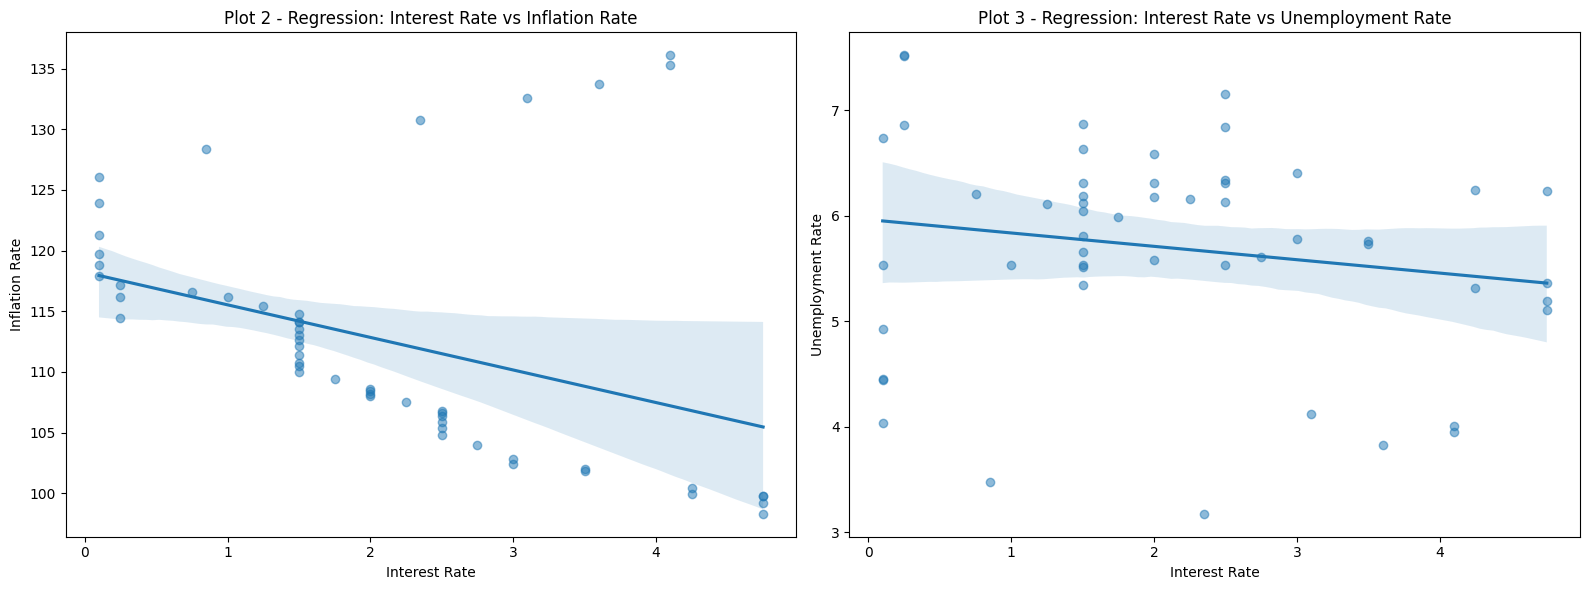

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Regression Plot of Interest Rate and Inflation Rate 
sns.regplot(x='Interest_Rate', y='Inflation_Rate', data=df, scatter_kws={'alpha':0.5}, ax=axes[0])
axes[0].set_title('Plot 2 - Regression: Interest Rate vs Inflation Rate')
axes[0].set_xlabel('Interest Rate')
axes[0].set_ylabel('Inflation Rate')

# Regression Plot of Interest Rate and Unemployment Rate 
sns.regplot(x='Interest_Rate', y='Unemployment_Rate', data=df, scatter_kws={'alpha':0.5}, ax=axes[1])
axes[1].set_title('Plot 3 - Regression: Interest Rate vs Unemployment Rate')
axes[1].set_xlabel('Interest Rate')
axes[1].set_ylabel('Unemployment Rate')

# Adjust Layout  and Show Graph
plt.tight_layout()
plt.show()

### Observation from Time series Plot 2 and Plot 3:
- The left graph shows a negative correlation trend: When interest rates rise, inflation falls. This suggests that inflation is likely to be suppressed in a higher interest rate environment.
- The right graph shows a more scattered relationship, without a clear trend, but there is a slight negative correlation overall: when interest rates increase, unemployment falls slightly, but the relationship is not strong.

**Outliers:**
- In the right graph, there are several groups of higher or lower unemployment rates far away from the main data clusters, such as points where the unemployment rate reaches 7% and above. These points may correspond to economic recessions in specific periods or abnormal fluctuations in unemployment during special events (such as epidemics).
- In the left graph, there are some points in the upper right and upper left corners that are far away from the main data group, and these points may be outliers. For example, the inflation rate rose sharply in 2022 and 2023. These data points may be caused by global supply chain problems, rising energy prices, or other economic shocks at that time.  

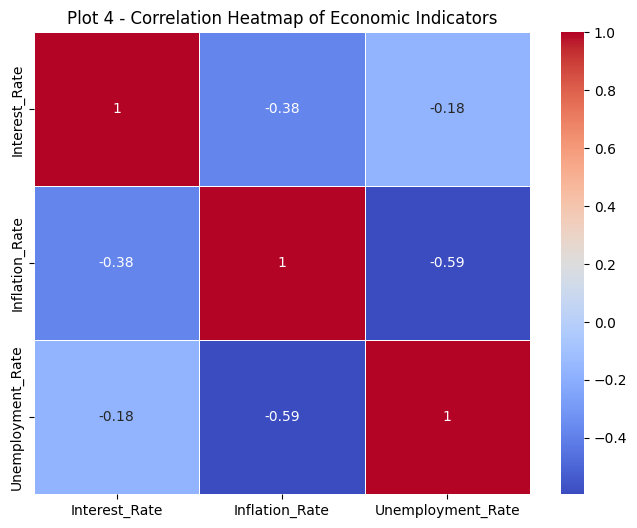

In [160]:
# Correlation Heatmap 
correlation_matrix = df[['Interest_Rate', 'Inflation_Rate', 'Unemployment_Rate']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Plot 4 - Correlation Heatmap of Economic Indicators')
plt.show()

### Observation from Time series Plot 4:
- **Interest Rate vs. Inflation Rate:** The correlation coefficient is -0.38, indicating that they have a **moderate negative correlation**. This is consistent with economic theory, which generally shows that inflation decreases when interest rates rise.
- **Interest Rate vs. Unemployment Rate:** The correlation coefficient is -0.18, indicating that the **negative correlation** between them is weak. The relationship between interest rates and unemployment rates is more complex and does not necessarily show a strong linear relationship.
- **Inflation Rate vs. Unemployment Rate:** The correlation coefficient is -0.59, indicating that they have a **moderate to strong negative correlation**. This is consistent with the "Phillips Curve" theory in economics, which shows that inflation and unemployment rates generally show a negative correlation.

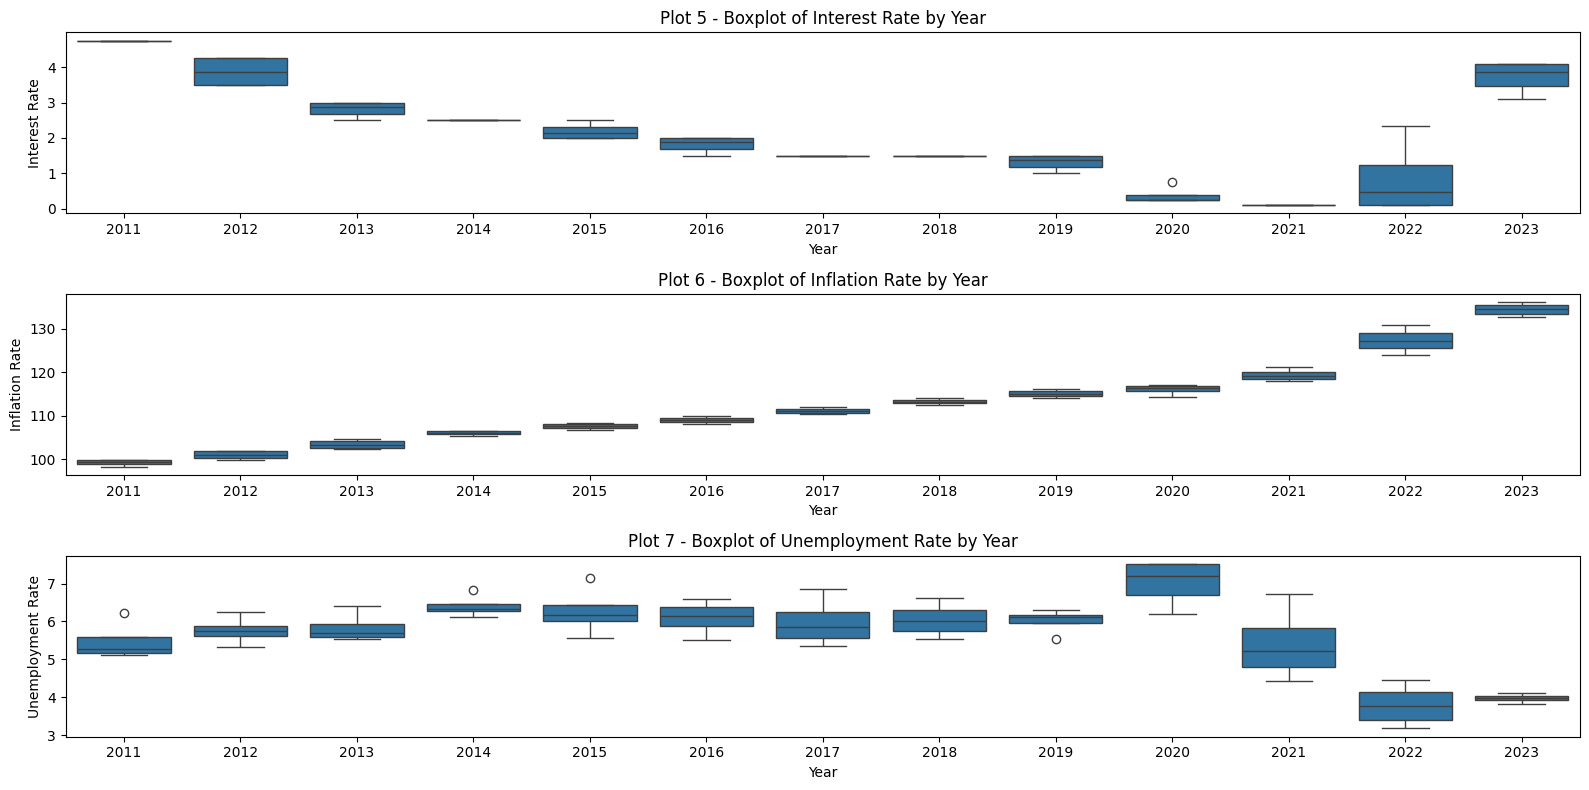

In [161]:
df['Year'] = df.index.year  # Extract the year
plt.figure(figsize=(16, 8))

# Box Plot of Interest Rate
plt.subplot(3, 1, 1)
sns.boxplot(x='Year', y='Interest_Rate', data=df)
plt.title('Plot 5 - Boxplot of Interest Rate by Year')
plt.xlabel('Year')
plt.ylabel('Interest Rate')

# Box Plot of Inflation Rate
plt.subplot(3, 1, 2)
sns.boxplot(x='Year', y='Inflation_Rate', data=df)
plt.title('Plot 6 - Boxplot of Inflation Rate by Year')
plt.xlabel('Year')
plt.ylabel('Inflation Rate')

# Box Plot of Unemployment Rate
plt.subplot(3, 1, 3)
sns.boxplot(x='Year', y='Unemployment_Rate', data=df)
plt.title('Plot 7 - Boxplot of Unemployment Rate by Year')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')

# Layout and show graph
plt.tight_layout()
plt.show()

### Observation from Time series Plot 5, Plot 6, and Plot 7:：
The following patterns and characteristics can be observed from the box plot:

#### 1. **Interest Rate**
- **Trend Change**:
 - Between 2011 and 2020, interest rates have generally remained at a low level with a smaller range of fluctuations, indicating that monetary policy during this period was relatively stable.
 - However, in 2022 and 2023, there is a significant increase in interest rates. This is manifested as an upward movement of the box in the box plot, indicating that the distribution of interest rates has expanded significantly in the past two years. This may be related to changes in the global economic environment or tightening of monetary policy.
- **Distributions and Outliers**:
 - During 2022 and 2023, the interest rate distribution is wider, which may be due to multiple adjustments in policy.
 - 2020 showed some outliers, which may be related to the epidemic at that time. Many central banks around the world adjusted interest rates during this year.

#### 2. **Inflation Rate**
- **Upward Trend**:
 - Inflation rate gradually increases starting in 2011 and reaches its peak in 2022 and 2023. An upward shift in the median and an increase in the spread of the distribution in these years can be clearly seen. This shows that the inflation rate has increased in recent years, which may be related to factors such as disruptions in global supply chains and rising energy prices.
- **Stability of Distribution**:
 - Between 2011 and 2021, the inflation rate is relatively stable, the distribution is narrow, and the box plot height is small. This means that price level movements were more consistent over this period.
 - But in 2022, the height of the box plot increases significantly, showing that inflation has become more volatile during the year.

#### 3. **Unemployment Rate**
- **General Trends and Fluctuations**:
 - From 2011 to 2019, the unemployment rate remained roughly stable, but in 2020 (during the outbreak), the distribution of the unemployment rate suddenly widened and the median rose, indicating that the unemployment rate fluctuated significantly during the year.
 - Then in 2021 and 2022, the unemployment rate gradually recovers and levels off in 2023.
- **Observations of outliers**:
 - In the boxplot, there were some outliers (dots outside the box) in the unemployment rate in 2011 and 2015, which may have been the result of some specific economic events or policy adjustments at that time.

### Summarize
1. **Interest Rates**: Relatively stable from 2011 to 2020, but rise sharply in 2022 and 2023, and the distribution range becomes wider.
2. **Inflation rate**: The overall trend is upward, especially the fluctuations will increase in 2022 and 2023, showing significant changes in the economic environment and prices.
3. **Unemployment rate**: It remained stable in most years, but increased significantly in 2020 due to the impact of the epidemic, and gradually recovered thereafter.

These charts illustrate the shock to the global economy during 2020 and 2022, as well as the impact of monetary and economic policies. The significant changes in these time points are the focus of further in-depth analysis later to understand the economic factors behind them.

---

# 3. STR Decomposition

Focus now on the unemployment timeseries.
- **Split the data** into training and testing series, selecting the **testing series to be the
last three years of the data (2021-2023)**.
- Manually step through the **STR decomposition process** on the training data, as
described in the course material.
- **Visualise and interpret** each of the components of
the STR decomposition for unemployment. (Hint: wish to validate the
output of manual process against an automated modelling approach.)

In [162]:
# Split the data 
train = df['2011':'2020']['Unemployment_Rate']  # 2011-2020
train = train.to_frame() 
train.columns = ['Unemployment_Rate']  

test = df['2021':]  # 2021-2023

In [163]:
train.head()

,Unemployment_Rate
Datetime,
2011-03-01,6.229757
2011-06-01,5.191075
2011-09-01,5.364334
2011-12-01,5.106490
2012-03-01,6.240249


## 3.1 Automated modelling approach

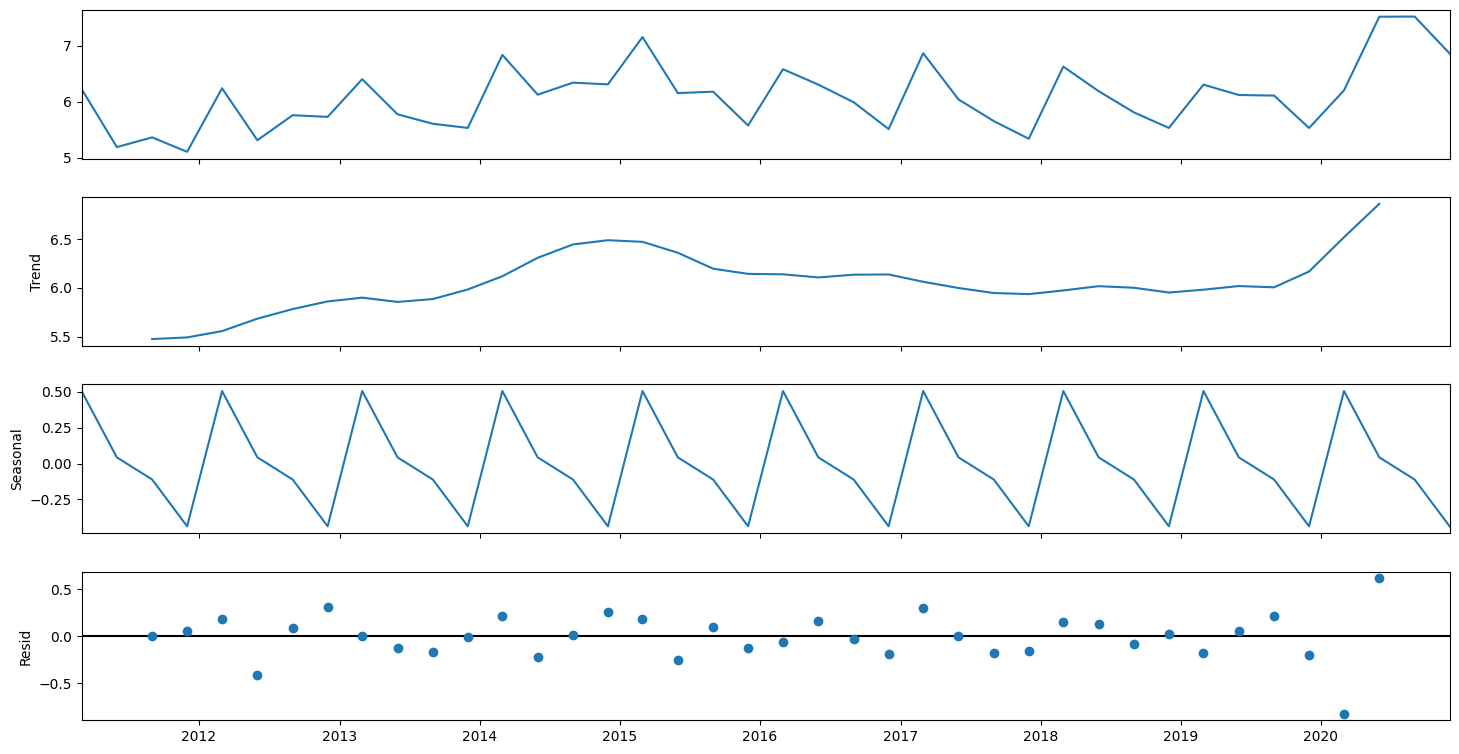

In [164]:
from statsmodels.tsa.seasonal import seasonal_decompose

str_results = seasonal_decompose(train,period = 4)
fig = str_results.plot()
fig.set_size_inches((16, 8))

## 3.2 STR-Classical STR Decomposition

### 3.2.1 Isolate the Trend

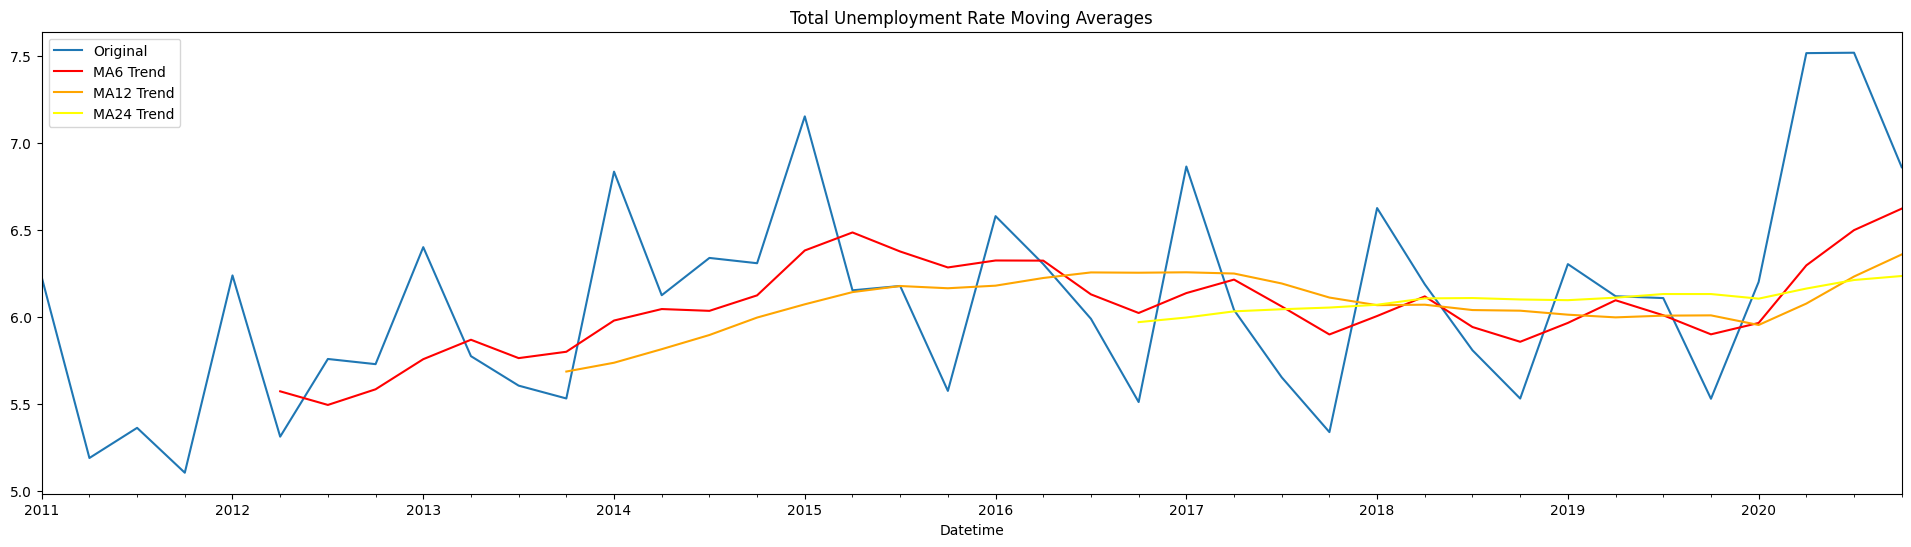

In [165]:
train['MA6 Trend'] = train['Unemployment_Rate'].rolling(6).mean()
train['MA12 Trend'] = train['Unemployment_Rate'].rolling(12).mean()
train['MA24 Trend'] = train['Unemployment_Rate'].rolling(24).mean()

fig, ax = plt.subplots(figsize=(24, 6))
train['Unemployment_Rate'].plot(label='Original', ax=ax)
train['MA6 Trend'].plot(color='red', label='MA6 Trend', ax=ax)
train['MA12 Trend'].plot(color='orange', label='MA12 Trend', ax=ax)
train['MA24 Trend'].plot(color='yellow', label='MA24 Trend', ax=ax)

plt.title('Total Unemployment Rate Moving Averages')
plt.legend()
plt.show()

MA12 (orange) is a better choice. It finds a suitable balance between smoothness and trend sensitivity. Compared with MA6, it reduces the impact of noise; compared with MA24, it can respond to trend changes faster. Therefore, MA12 is the best choice for observing the medium-term trend of unemployment rate.

### 2. De-trend the series

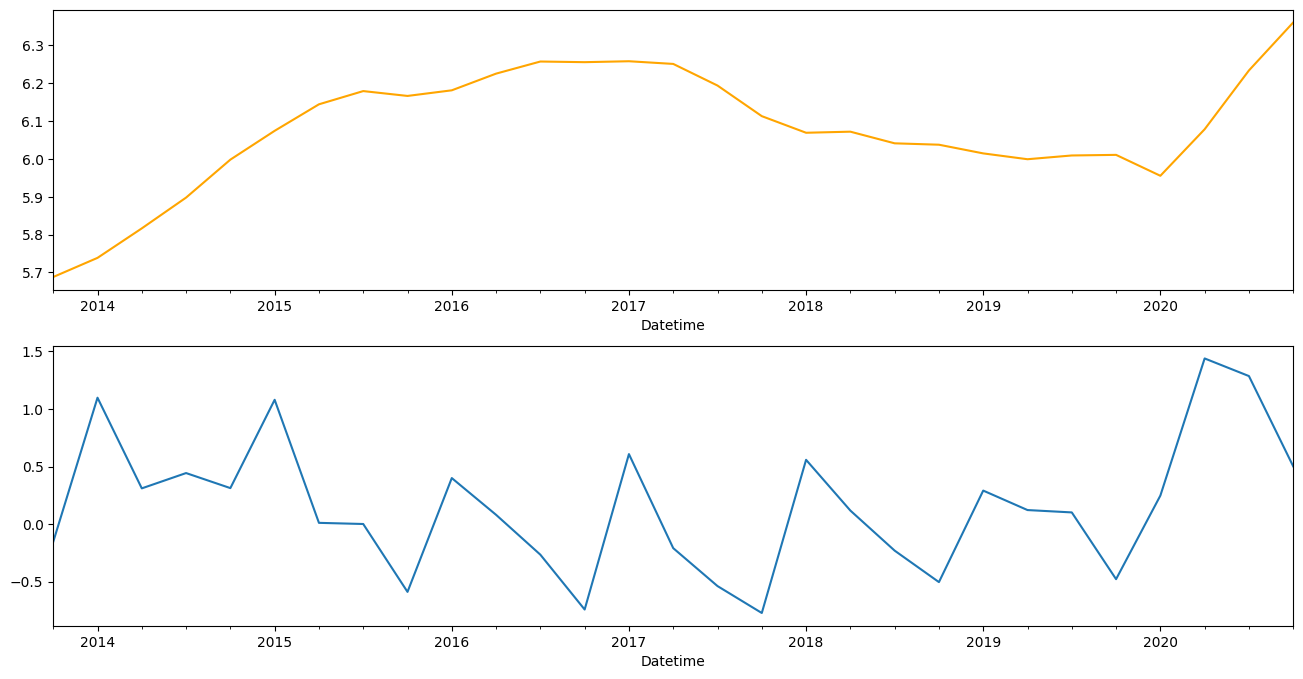

In [166]:
# De-trend data
train['De-trended'] = train['Unemployment_Rate'] - train['MA12 Trend']

fig, ax_detrended = plt.subplots(2, figsize=(16, 8))

# Get the start time of MA12 trend and detrended data
start_date = train['MA12 Trend'].dropna().index.min()
end_date = train['De-trended'].dropna().index.max()

# MA12 Trend Line
train['MA12 Trend'].plot(color='orange', label='MA12 Trend', ax=ax_detrended[0])
ax_detrended[0].set_xlim([start_date, end_date]) 

# Draw de-trended
train['De-trended'].plot(label='De-trended', ax=ax_detrended[1])
ax_detrended[1].set_xlim([start_date, end_date]) 

plt.show()

There is seasonal component in unemployment rate data, after de-trend the series.

### 3. Estimate seasonal component

In [167]:
import numpy as np

# Compute raw monthly means
raw_month_means = train.groupby(train.index.month)['De-trended'].mean()

# Adjust seasonal components to sum to zero
adjustment = raw_month_means.sum() / 12.0
month_means = raw_month_means - adjustment

# Generate a list of monthly means in order, making sure to start in May
month_list = month_means.tolist()[4:] + month_means.tolist()[:4]

# Calculate the number of repetitions needed to cover the length of the train DataFrame
repeat_count = (len(train) // len(month_list)) + 1

# Generate long enough seasonal_values
seasonal_values = np.tile(month_list, repeat_count)[:len(train)]

# Make sure seasonal_values is the same length as the train DataFrame (ie. The length is consistent)
train['Seasonal'] = seasonal_values

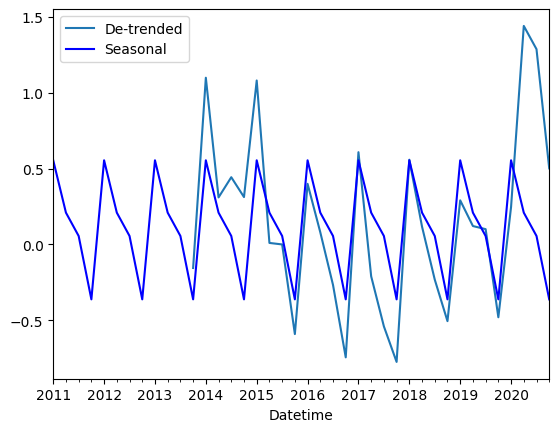

In [168]:
# Visualize
fig, ax_seasonal = plt.subplots()
train['De-trended'].plot(label='De-trended', ax=ax_seasonal)
train['Seasonal'].plot(color='blue', label='Seasonal', ax=ax_seasonal)
plt.legend()
plt.show()

The detrended data still exhibits some regularity and a pattern resembling that of the seasonal component between 2016 and 2020, demonstrating the significance of seasonality in the data.

### 4.Calculate the residual

In [169]:
# Residual
train['Residual'] = train['Unemployment_Rate']- train['MA12 Trend'] - train['Seasonal']

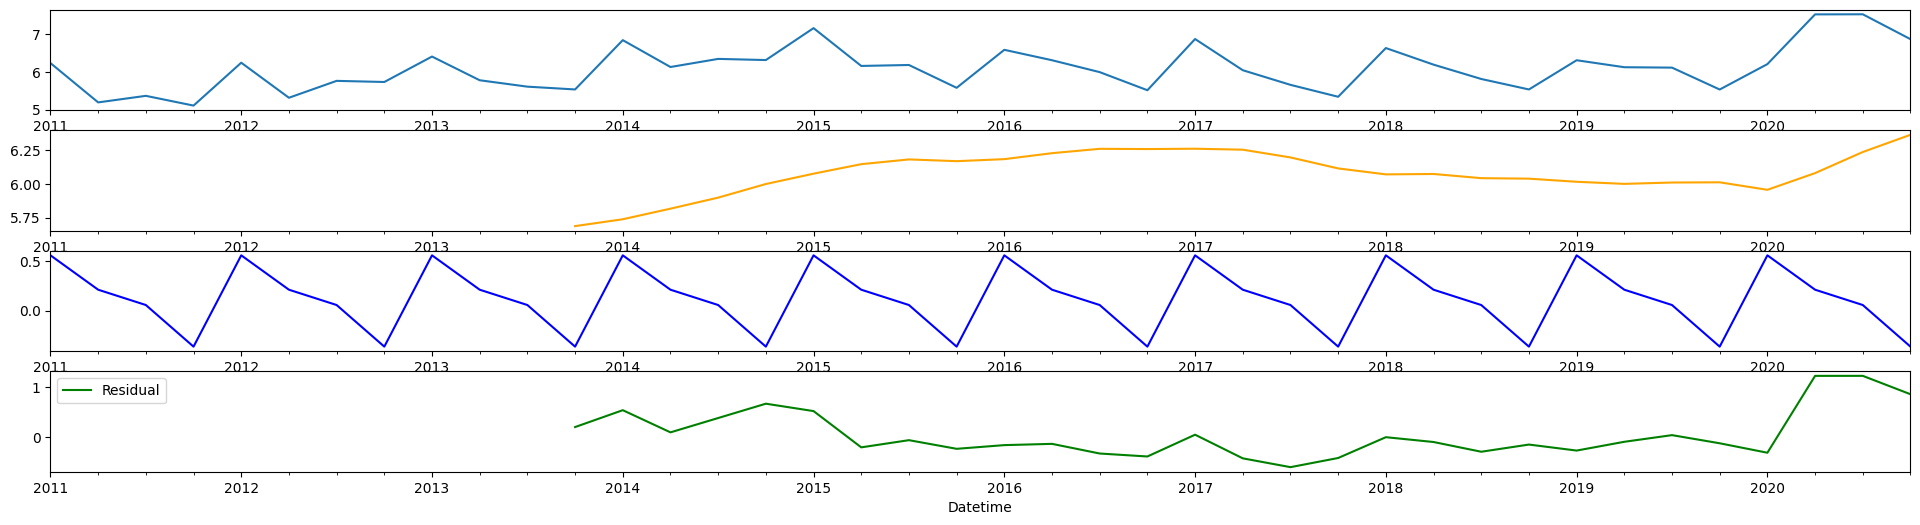

In [170]:
# Visualize
fig, ax_str = plt.subplots(4, figsize=(24,6))
train['Unemployment_Rate'].plot(label='Original', ax=ax_str[0])
train['MA12 Trend'].plot(color='orange', label='MA12 Trend', ax=ax_str[1])
train['Seasonal'].plot(color='blue', label='Seasonal', ax=ax_str[2])
train['Residual'].plot(color='green', label= 'Residual', ax=ax_str[3])
plt.legend()
plt.show()

## 3.3 Compare Automated VS Manual

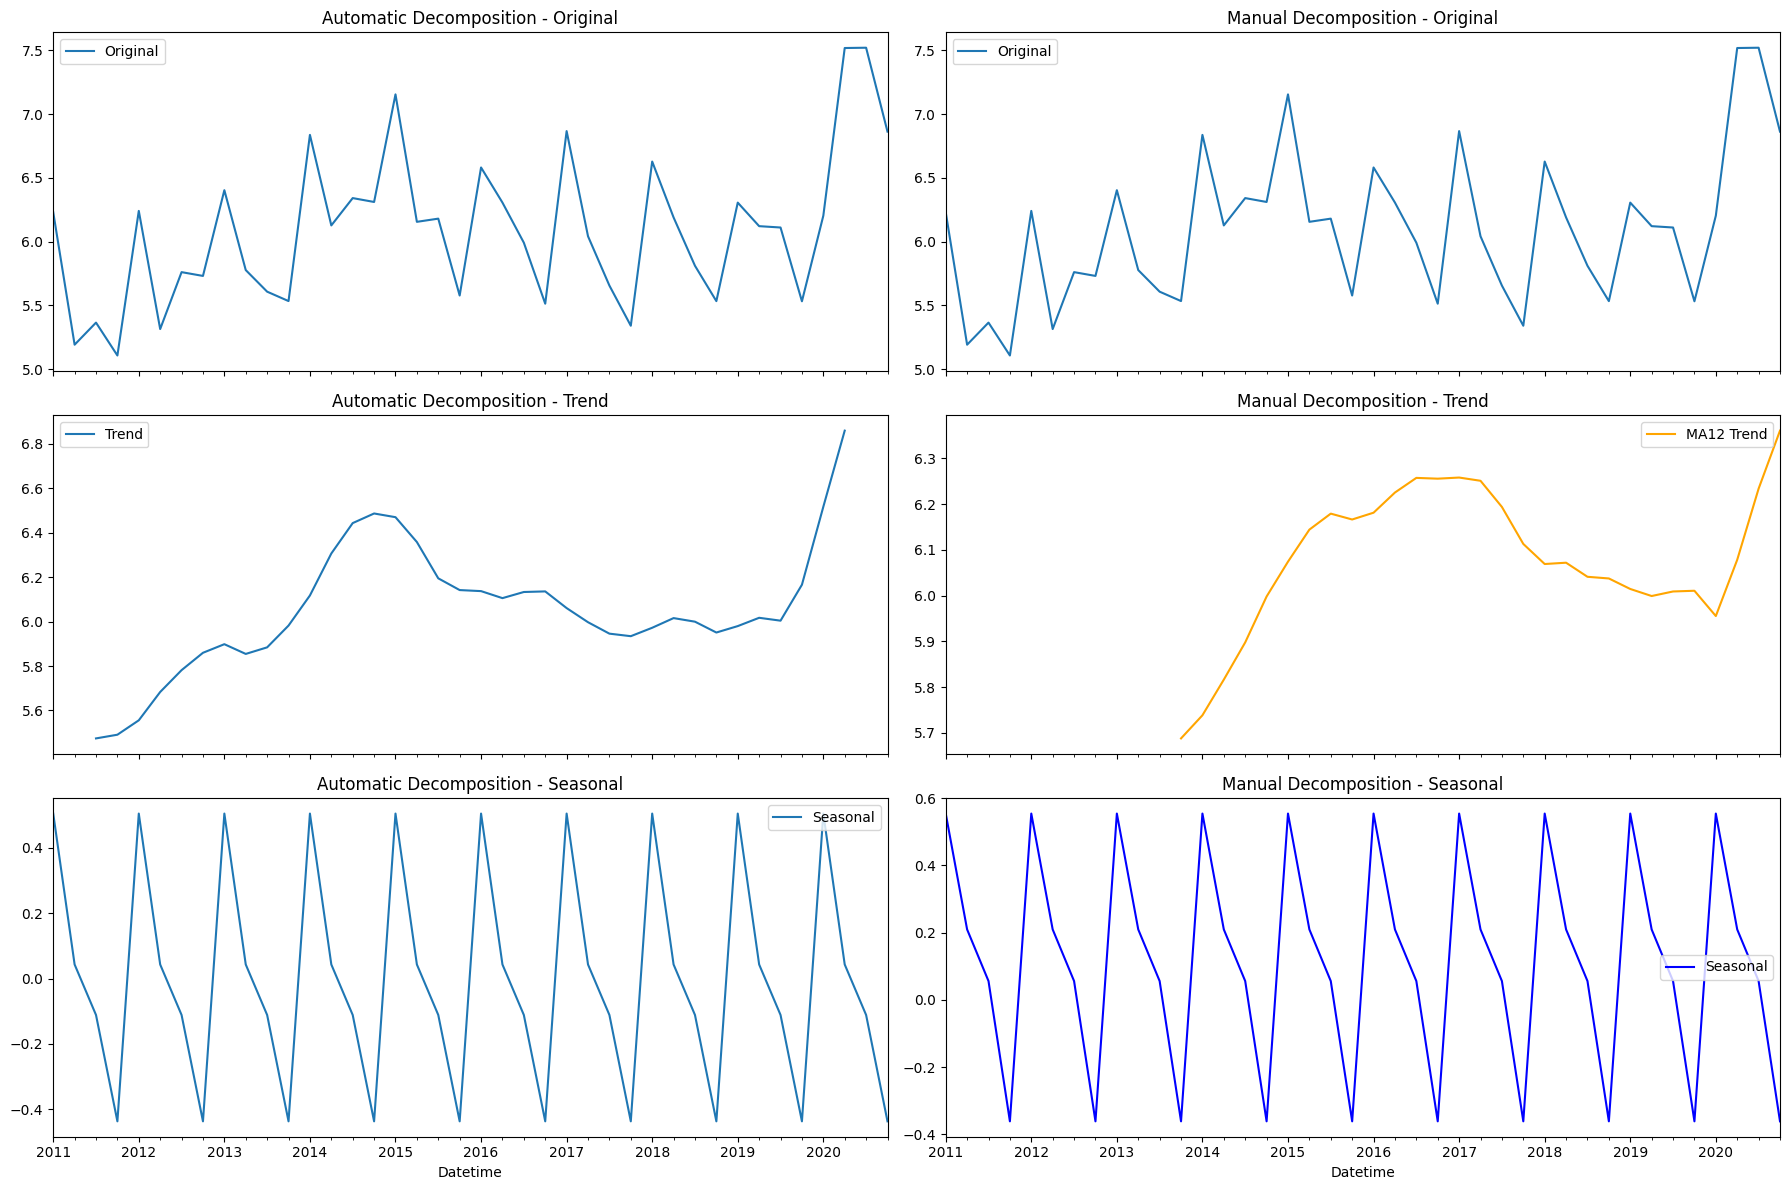

In [171]:
# Automated generated decomposition results
str_results = seasonal_decompose(train['Unemployment_Rate'], period=4)

# Ensure no Nan
str_results_resid = str_results.resid.dropna()
manual_residual = train['Residual'].dropna()

# Create a large canvas with two columns, the left one is automatically generated and the right one is manually generated
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

# Draw the automatically generated exploded view (left column)
train['Unemployment_Rate'].plot(ax=axes[0, 0], label='Original')
axes[0, 0].set_title('Automatic Decomposition - Original')
str_results.trend.plot(ax=axes[1, 0], label='Trend')
axes[1, 0].set_title('Automatic Decomposition - Trend')
str_results.seasonal.plot(ax=axes[2, 0], label='Seasonal')
axes[2, 0].set_title('Automatic Decomposition - Seasonal')

# Plotting manually generated decomposition diagrams (right column)
train['Unemployment_Rate'].plot(ax=axes[0, 1], label='Original')
axes[0, 1].set_title('Manual Decomposition - Original')
train['MA12 Trend'].plot(color='orange', label='MA12 Trend', ax=axes[1, 1])
axes[1, 1].set_title('Manual Decomposition - Trend')
train['Seasonal'].plot(color='blue', label='Seasonal', ax=axes[2, 1])
axes[2, 1].set_title('Manual Decomposition - Seasonal')

# Add legend and layout adjustments
for ax_row in axes:
    for ax in ax_row:
        ax.legend()

plt.tight_layout()
plt.show()

#### Original
The raw unemployment rate data shown is the **same** and is identical to the previous data. This shows the unprocessed data in order to provide a basic understanding of the data.

#### Trend
Left: Displays the trend extracted automatically through seasonal decomposition. This trend line shows the overall change in unemployment rate from 2011 to 2020, depicting a gradual rise, peaking around 2019, followed by a decline.

Right: This trend line is calculated manually using a 12-period moving average (MA12). It shows some similarities to the automatic decomposition but also presents slight deviations due to the smoothing level and parameter settings chosen manually.

#### Seasonal
The fluctuation range and periodicity of the two are almost the same, which shows that both manual and automatic methods can capture the seasonal characteristics of unemployment rate data well in extracting seasonal characteristics. 

### Summary 
The results of automatic and manual decomposition on raw data and seasonal patterns are very similar, indicating that the two methods can produce consistent results in both aspects.  
On the trend chart, while there are minor differences between the two approaches, the overall trend and seasonal patterns are consistent. This indicates that manual decomposition when properly adjusted, can achieve results comparable to automatic decomposition. The differences are mainly due to the different smoothing windows and the more complex calculation method of automatic decomposition.

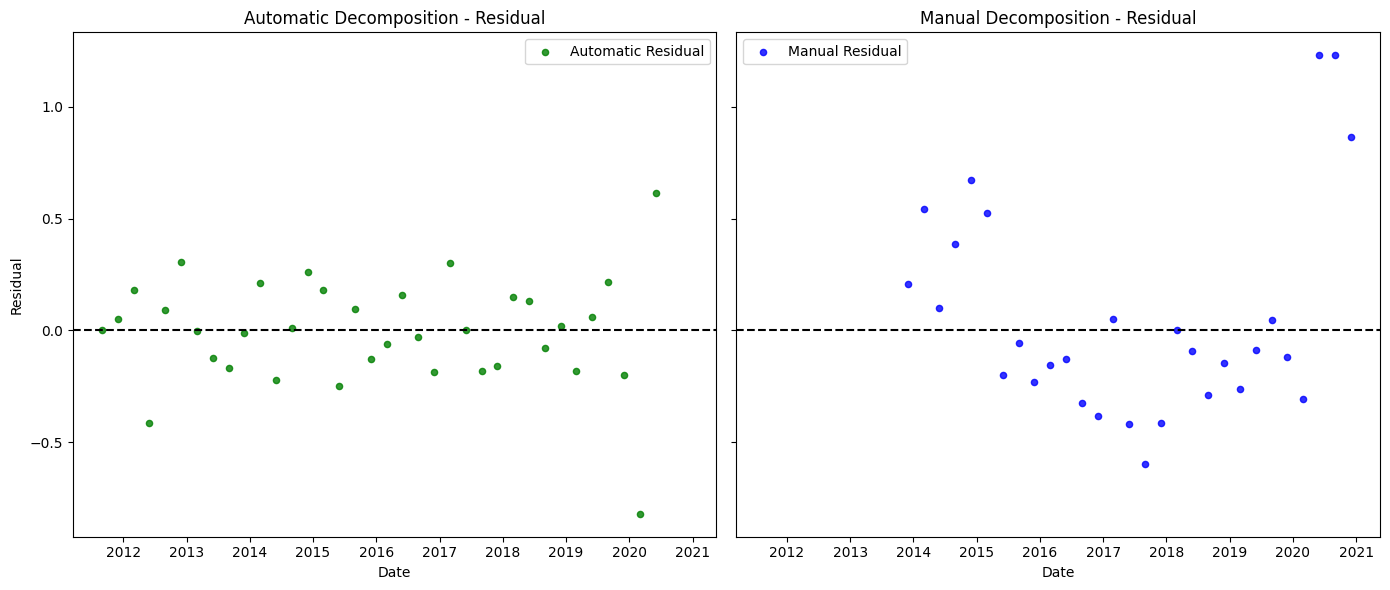

In [172]:
# Create a large canvas with two columns, the left side is the automatically generated residuals, and the right side is the manually generated residuals
fig, (ax_auto, ax_manual) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Draw the automatically generated residuals as a scatter plot (left column)
ax_auto.scatter(str_results_resid.index, str_results_resid, color='green', alpha=0.8, s=20, label='Automatic Residual')
ax_auto.axhline(0, linestyle='--', color='black')
ax_auto.set_title('Automatic Decomposition - Residual')
ax_auto.set_xlabel('Date')
ax_auto.set_ylabel('Residual')
ax_auto.legend()

# Plot manually generated residuals as a scatter plot (right column)
ax_manual.scatter(manual_residual.index, manual_residual, color='blue', alpha=0.8, s=20, label='Manual Residual')
ax_manual.axhline(0, linestyle='--', color='black')
ax_manual.set_title('Manual Decomposition - Residual')
ax_manual.set_xlabel('Date')
ax_manual.legend()

plt.tight_layout()
plt.show()

From the comparison of the two residual plots, the following differences can be observed:

#### 1. Automatic decomposition residuals (left figure)
The chart shows the residuals calculated after the automatic decomposition. The residual points fluctuate around the 0-axis without any clear systematic pattern, indicating that the model fits the data reasonably well. However, there is still some variability in the residual distribution.

#### 2. Manually decomposed residuals (right figure)
The residuals from the manual decomposition show a noticeable trend and bias over the time series. After 2014, most of the residual points are above the 0-axis and gradually increase. This suggests that the manual decomposition method may have introduced biases when capturing the trend or seasonal components, leading to less accurate model fitting compared to the automatic method.

### Summary
The residuals from the automatic decomposition are more evenly distributed, indicating a better model fit. In contrast, the residuals from the manual decomposition show systematic bias, suggesting that further adjustments or parameter tuning may be needed to improve the fit accuracy of the manual method.

This comparison helps to verify the accuracy and effectiveness of the decomposition method and help further optimize the model.

---

# 4. Timeseries Models

- Fit an **ARIMA model** for the **trend-cycle component** of STR decomposition of
the training data and **interpret the estimated model parameters**.
- Using the STR components that estimated in tasks 3b and 4a, **produce forecasts**
of Queensland unemployment for the test data series. Include the **uncertainty** in the
forecasts and **visualise** the predictions.

In [173]:
simple_pred = simple_pred = pd.DataFrame(index=test.index)

## 4.1 Simple forecasting benchmarks

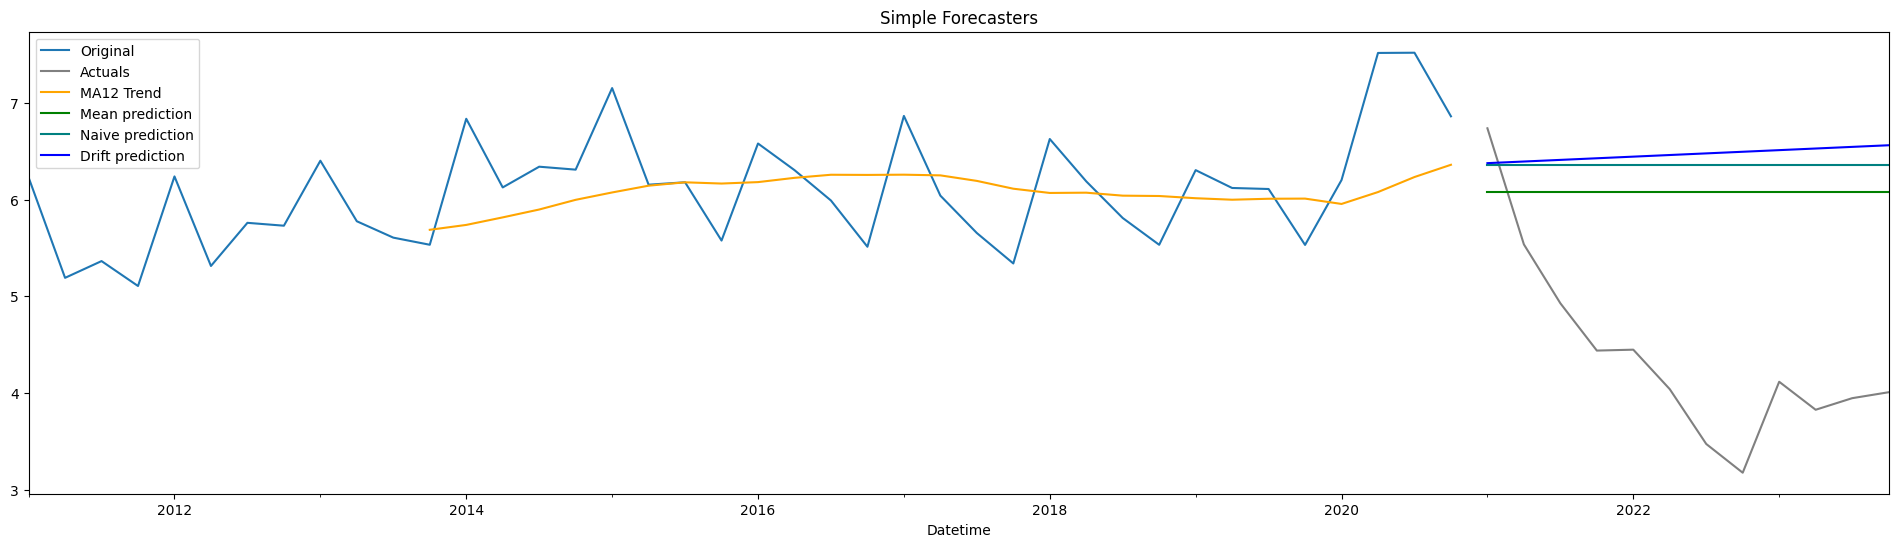

In [174]:
# Make sure the data in the 'MA12 Trend' column is numeric and has no missing values.
train['MA12 Trend'] = pd.to_numeric(train['MA12 Trend'], errors='coerce')
train['MA12 Trend'].ffill()

# Generate a DataFrame of prediction data
simple_pred = pd.DataFrame(index=test.index)

# MEAN Forecast
mean_MA12 = train['MA12 Trend'][:'2020'].mean()
simple_pred['mean'] = [mean_MA12 for t in range(len(simple_pred))]

# NAIVE Forecast
naive_MA12 = train['MA12 Trend'].loc['2020'].iloc[-1]
simple_pred['naive'] = [naive_MA12 for t in range(len(simple_pred))]

# DRIFT Forecast
drift_slope_MA12 = (train['MA12 Trend'].loc['2020'].iloc[-1] - train['MA12 Trend'].iloc[11]) / len(train)
simple_pred['drift'] = [train['MA12 Trend'].loc['2020'].iloc[-1] + (t + 1) * drift_slope_MA12 for t in range(len(simple_pred))]

# Make sure all prediction columns are numeric
simple_pred = simple_pred.apply(pd.to_numeric)

# Plot
fig, ax_simple_pred = plt.subplots(figsize=(24, 6))
train['Unemployment_Rate'].plot(label='Original', ax=ax_simple_pred)
test['Unemployment_Rate'].plot(color='grey', label='Actuals', ax=ax_simple_pred)
train['MA12 Trend'][:'2020'].plot(color='orange', label='MA12 Trend', ax=ax_simple_pred)
simple_pred['mean'].plot(color='green', label='Mean prediction', ax=ax_simple_pred)
simple_pred['naive'].plot(color='teal', label='Naive prediction', ax=ax_simple_pred)
simple_pred['drift'].plot(color='blue', label='Drift prediction', ax=ax_simple_pred)

plt.title('Simple Forecasters')
plt.legend()
plt.show()

As can be seen from the figure, none of these simple models can fully capture the true changes in the test data, especially the sharp decline and fluctuations in the unemployment rate after 2021, which suggests that we may need more complex models to make more accurate predictions.

## 4.2 Modelling trends with ARIMA
ARIMA forecaster for MA

### 4.2.1 Check for Stationarity

The series is non-stationary because it decreases dramatically after 2021. So try the first difference. 

<Axes: xlabel='Datetime'>

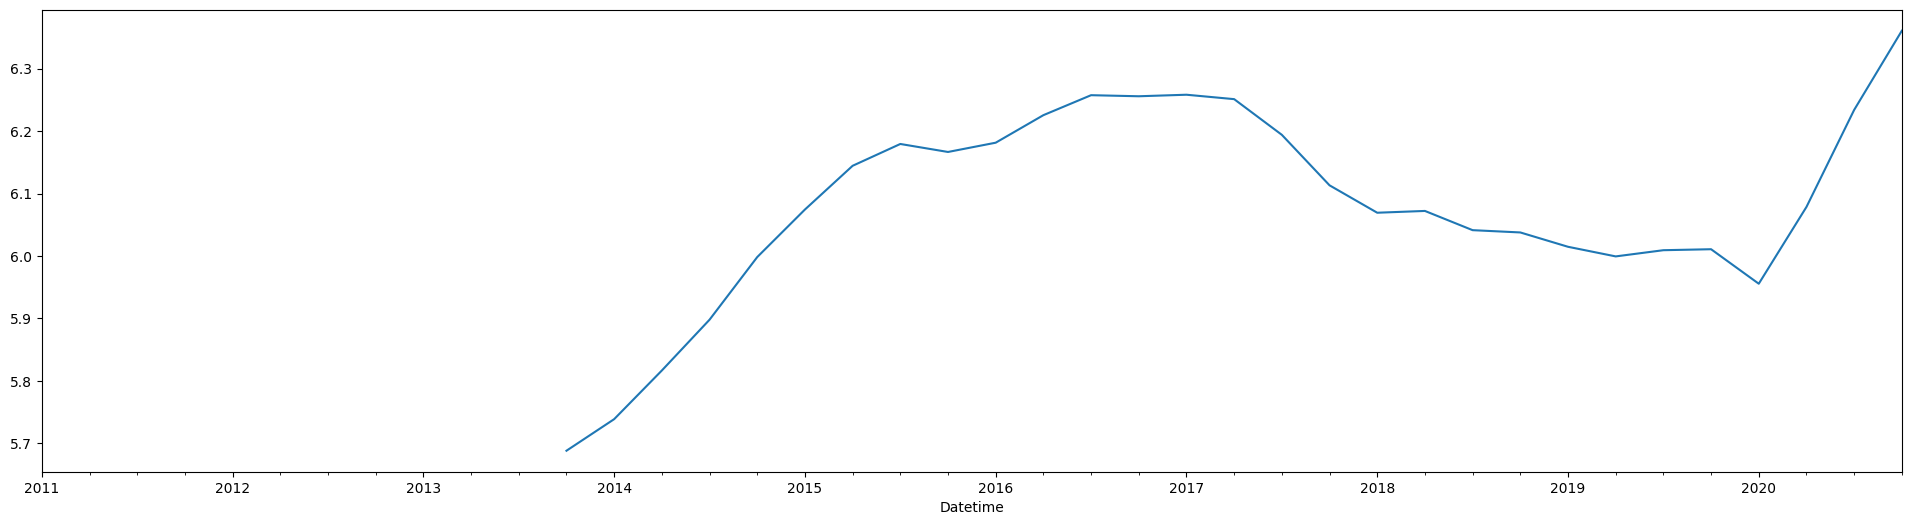

In [175]:
trend = train['MA12 Trend']
trend.plot(figsize=(24,6))

Based on the plot, the time series does not fully meet the criteria for **stationarity**. 

**Constant Mean/Roughly Horizontal:**
- Condition: The mean of the time series should remain constant or fluctuate around a fixed value.
- Observation: From the plot, it's evident that the mean changes over time, especially from 2014 to 2020, with an upward trend after 2020. This violates the mean stationarity condition.

**Constant Variance:**
- Condition: The variance (the range of fluctuations) should remain constant over time.
- Observation: The plot shows that the series has different levels of variance at different time intervals, particularly with higher variability from 2014 to 2017. This suggests the variance is not stable.

**No Predictable Long-term Patterns/Constant Autocorrelation:**
- Condition: If the time series is stationary, the autocorrelation should decay rapidly.
- Observation: This cannot be directly inferred from the plot alone; further analysis with an Autocorrelation Function (ACF) plot or the Augmented Dickey-Fuller (ADF) test is required.


The time series does not meet the criteria for stationarity. Differencing or detrending the data might be necessary to achieve stationarity.

<Axes: xlabel='Datetime'>

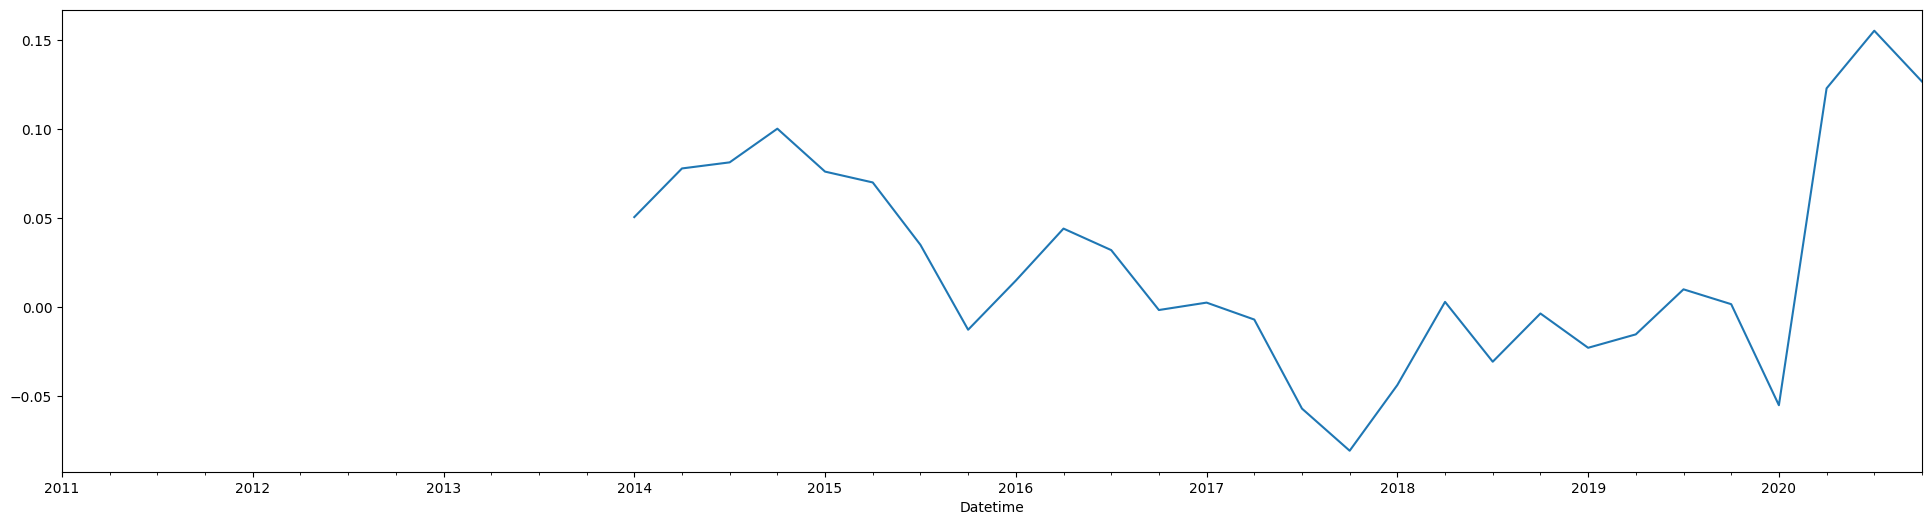

In [176]:
trend_d1 = train['MA12 Trend'].diff()
trend_d1.plot(figsize=(24,6))

**Trend_d1:**
- The mean of the series varies over different time periods, especially showing a sharp increase after 2019. Therefore, it does not meet the mean stationarity condition. 
- The variance of the series changes significantly over time, particularly with increased fluctuations after 2019. This indicates the variance is not stable.
These shows that the data still has trend characteristics and does not meet the stationarity, which means that we need to do diff further.

<Axes: xlabel='Datetime'>

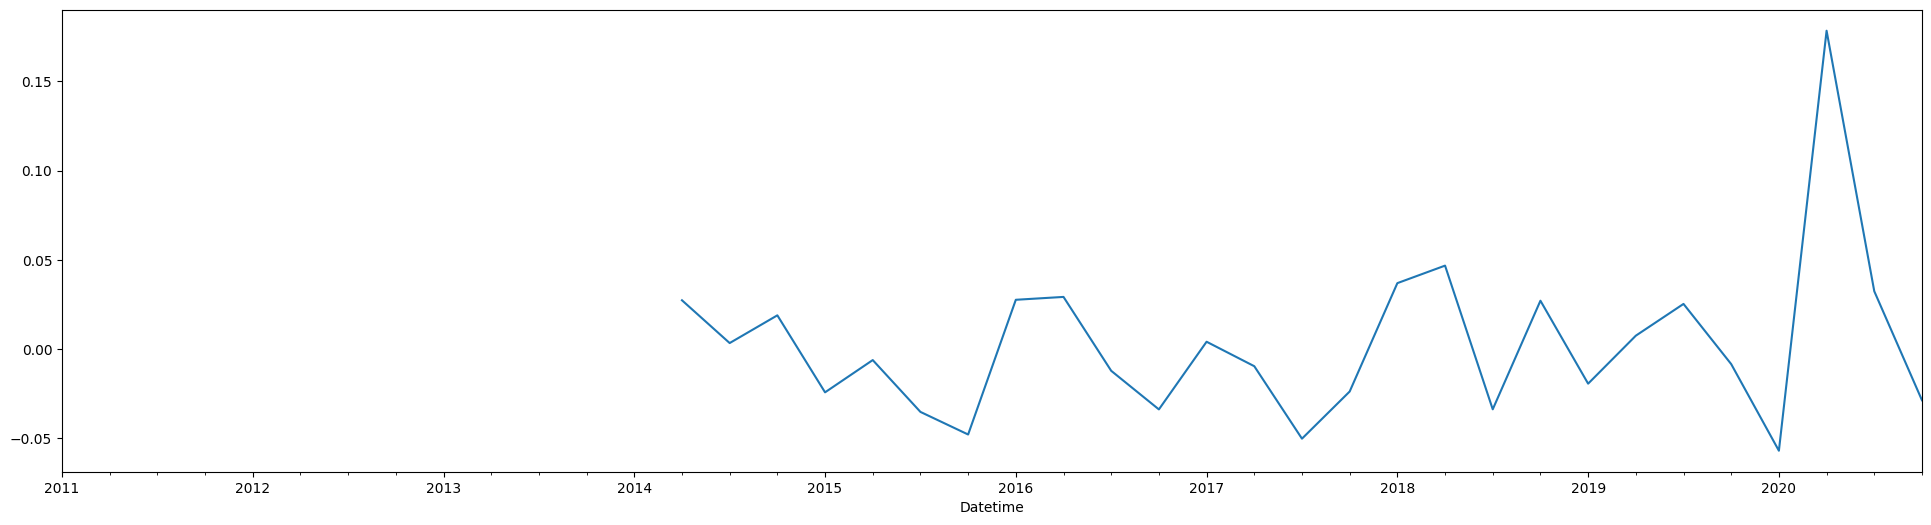

In [177]:
trend_d2 = trend_d1.diff()
trend_d2.plot(figsize=(24,6))

**Trend_d2 :**
- The mean appears **relatively stable over most of the period**, with no clear upward or downward trend. Thus, it meets the mean stationarity condition. 
- Although there is a notable spike around 2020, the overall range of fluctuations is **relatively consistent**. Therefore, it largely meets the variance stationarity condition, but there may be some instability at extreme points (e.g., around 2020). 
- The autocorrelation cannot be confirmed directly from the plot; further analysis using an Autocorrelation Function (ACF) plot or the Augmented Dickey-Fuller (ADF) test is needed.

<Axes: xlabel='Datetime'>

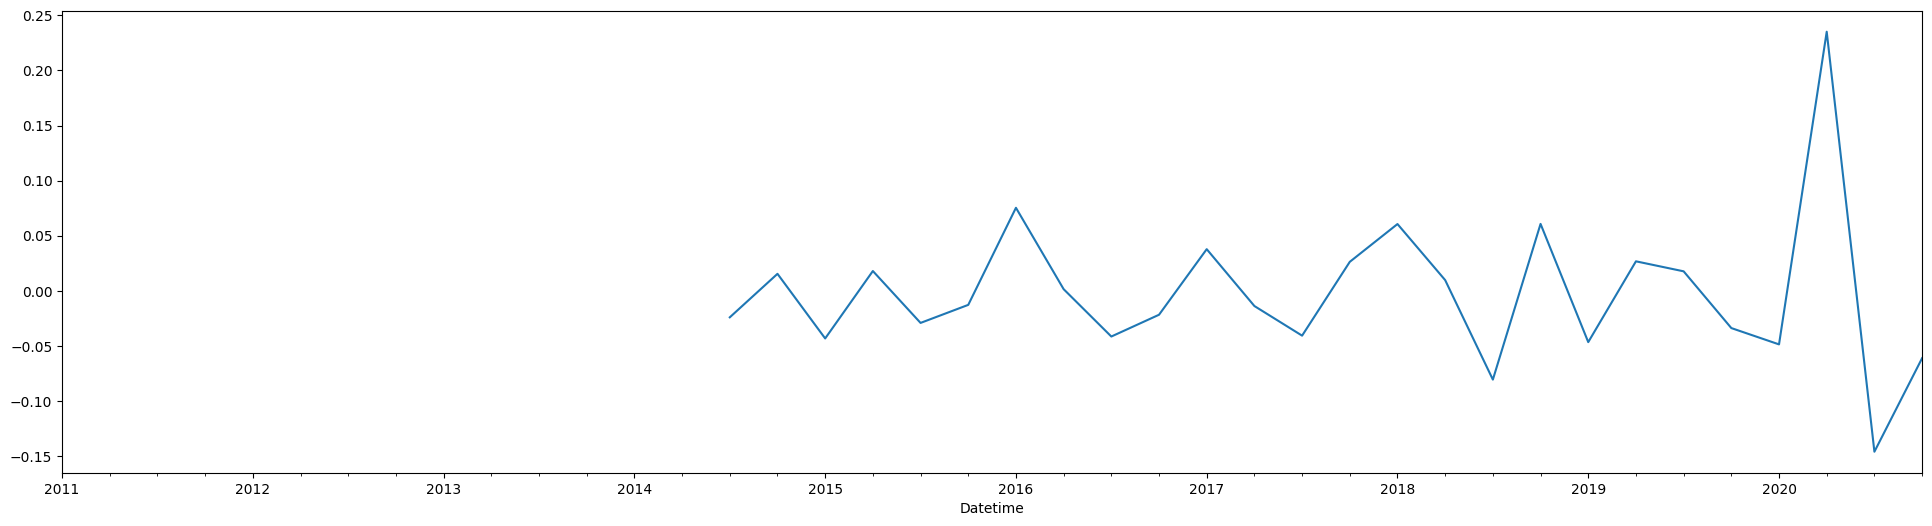

In [178]:
trend_d3 = trend_d2.diff()
trend_d3.plot(figsize=(24,6))

Trend_d3 has almost same characteristics with Trend_d2.

### 4.2.2 Fit a lower order model

In [179]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

In [180]:
trend_d2 = trend_d1.dropna()

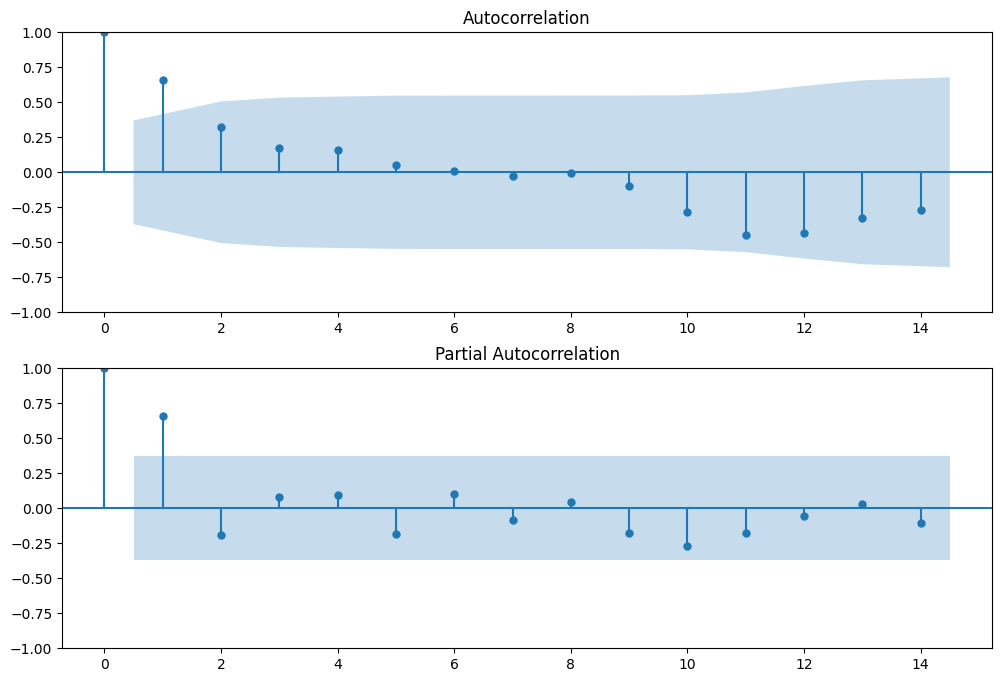

In [181]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_d2, lags=14, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_d2, lags=14, ax=ax2)

According to ACF and PACF graphs, ARIMA parameters can be set as p=2, d=1, q=2, because the PACF value at lag 2 and ACF value at lag 1 are significantly above the confidence interval, and none of the subsequent lag points is significant, after differencing once. Best ARIMA parameters need to check AIC and BIC results.

### 4.2.3 Fit first ARIMA model

Starting with p =1, d=1  and q=0

In [182]:
arima_1_1_0 = ARIMA(train['MA12 Trend'], order=(1, 1, 0)).fit()
print(arima_1_1_0.summary())

                               SARIMAX Results                                
Dep. Variable:             MA12 Trend   No. Observations:                   40
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  40.183
Date:                Wed, 23 Oct 2024   AIC                            -76.366
Time:                        11:52:35   BIC                            -73.039
Sample:                    03-01-2011   HQIC                           -75.172
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7707      0.179      4.318      0.000       0.421       1.121
sigma2         0.0018      0.000      5.630      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   0.16   Jarque-

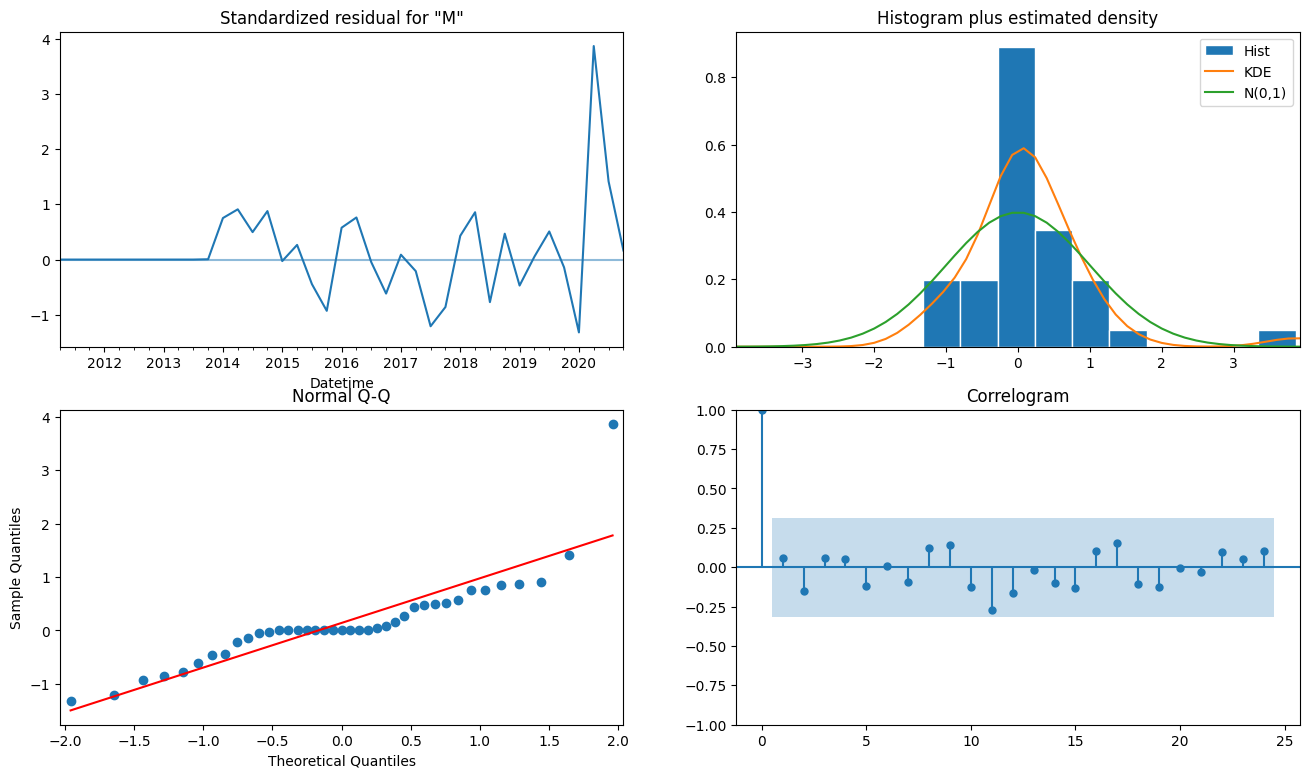

In [183]:
from statsmodels.graphics.tsaplots import plot_predict
fig = plt.figure(figsize=(16, 9))
fig = arima_1_1_0.plot_diagnostics(fig=fig, lags=24)

**Standardized Residual Plot (top left):**
- Normally, this plot shows the standardized residual values over time. Ideally, the residuals should be centered around zero with no obvious trends or patterns.
- In this plot, the residuals fluctuate around zero for most of the period, but there is a significant deviation around 2020, indicating potential anomalies or insufficient model fitting in that period.

**Residual Histogram and Density Estimate(top right corner):**
- Normally, the histogram shows the distribution of the residuals, with the orange curve representing the kernel density estimate (KDE) of the residuals and the green line representing the reference standard normal distribution (mean of 0 and variance of 1).
- The residual distribution roughly follows the normal distribution, but there is some deviation in the extreme (right) values.

**Normal Q-Q Plot(lower left corner):**
- Normally, this plot compares the distribution of the residuals with the theoretical normal distribution. If the residuals are normally distributed, the points should lie close to the red 45-degree line.
- Most points are near the red line, but there are deviations in the tails (especially on the right), suggesting that the residuals may not fully conform to a normal distribution at the extremes.

**Autocorrelation plot (Correlogram, lower right corner):**
-Normally, this plot shows the autocorrelation of the residuals, with the blue shaded area representing the confidence interval. If the autocorrelation coefficients (blue dots) fall within this range, it indicates that the residuals are independent.
- Most points fall within the confidence interval except for lag 1 and a few other lags, suggesting that the residuals are mostly independent.

**Summarize:**
The residual diagnostic plot indicates that most of the model's residuals meet the normality and independence criteria, but the significant deviation around 2020 suggests a need for further analysis or model adjustments for that specific period.

### 4.2.4 Fit Higher-Order ARIMA models
Increase the AR lag parameter and re-fit:

In [184]:
arima_2_1_0 = ARIMA(train['MA12 Trend'], order=(2, 1, 0)).fit()
print(arima_2_1_0.summary())

                               SARIMAX Results                                
Dep. Variable:             MA12 Trend   No. Observations:                   40
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  40.315
Date:                Wed, 23 Oct 2024   AIC                            -74.631
Time:                        11:52:36   BIC                            -69.640
Sample:                    03-01-2011   HQIC                           -72.840
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8387      0.220      3.810      0.000       0.407       1.270
ar.L2         -0.1102      0.279     -0.396      0.692      -0.656       0.436
sigma2         0.0018      0.000      5.125      0.0

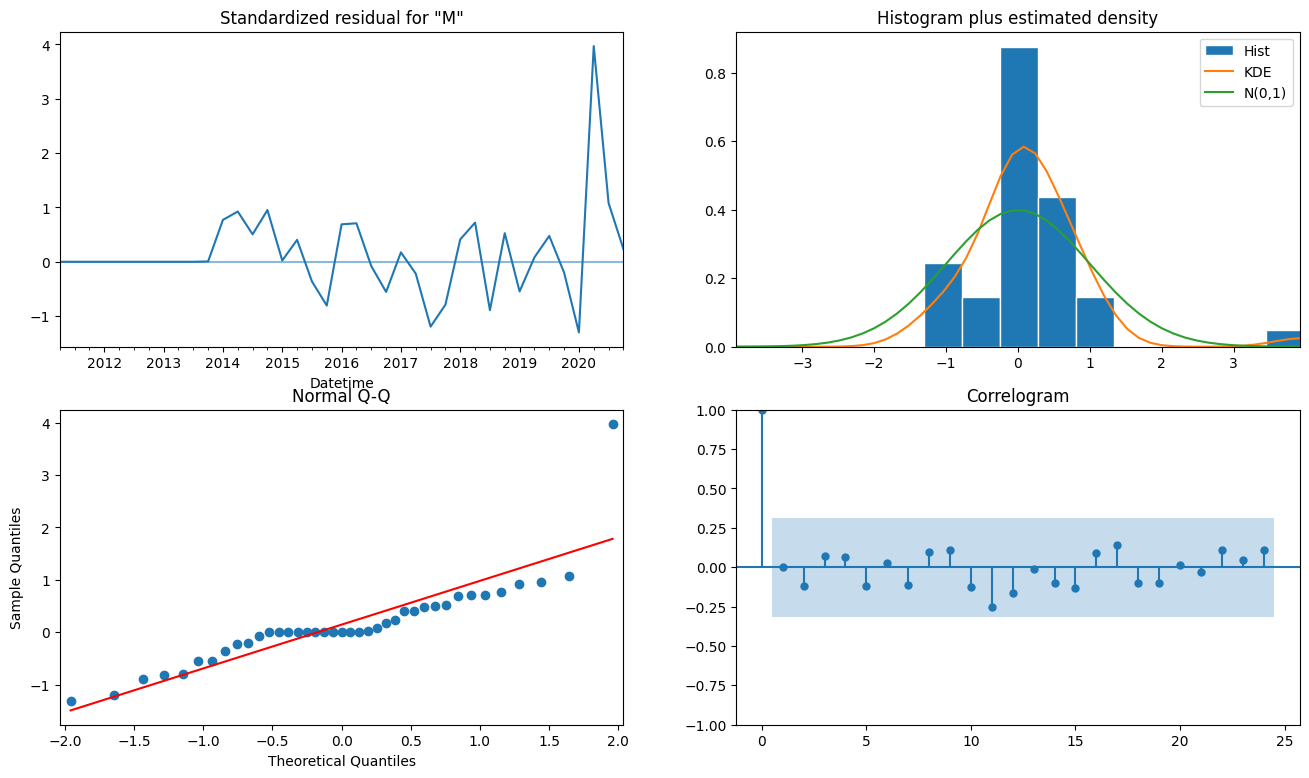

In [185]:
fig = plt.figure(figsize=(16, 9))
fig = arima_2_1_0.plot_diagnostics(fig=fig, lags=24)

Although there are anomalies in 2020, this model fits the data rather well for the majority of the time span.
The tail deviates, displaying some skewness or extreme values, but the residuals generally follow the normal distribution.
The autocorrelation plot indicates that the residuals are generally random, but some lags are substantial, and the model may need to be further adjusted to eliminate these autocorrelations.


### 4.2.5 Compare the goodness of fit, then continue

Looking at the summary outputs, the AIC for ARIMA(1,1,0) is -76, while for ARIMA(2,1,0) it is -74. A similar change is observed in the BIC. Lower AIC and BIC scores are preferred, so this is encouragement to look for further improvements.

At the next iteration, try increasing the MA term to q=1:

In [186]:
arima_1_1_1 = ARIMA(train['MA12 Trend'], order=(1, 1, 1)).fit()
print(arima_1_1_1.summary())

                               SARIMAX Results                                
Dep. Variable:             MA12 Trend   No. Observations:                   40
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  40.381
Date:                Wed, 23 Oct 2024   AIC                            -74.762
Time:                        11:52:37   BIC                            -69.772
Sample:                    03-01-2011   HQIC                           -72.972
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6671      0.410      1.627      0.104      -0.137       1.471
ma.L1          0.2007      0.388      0.518      0.605      -0.559       0.960
sigma2         0.0018      0.000      4.934      0.0

### Summary
According to the summaries above, AIC and BIC have the lowest scores with ARIMA(1,1,0). So, ARIMA(1,1,0) is preferred.

## 4.3 Forecasting with ARIMA

In [187]:
arima_fcst = arima_1_1_0.get_forecast(steps=24)
arima_predictions = pd.DataFrame(arima_fcst.predicted_mean)
arima_predictions.rename(columns={"predicted_mean": "trend"}, inplace=True)

### 4.3.1 Mean Trend Prediction

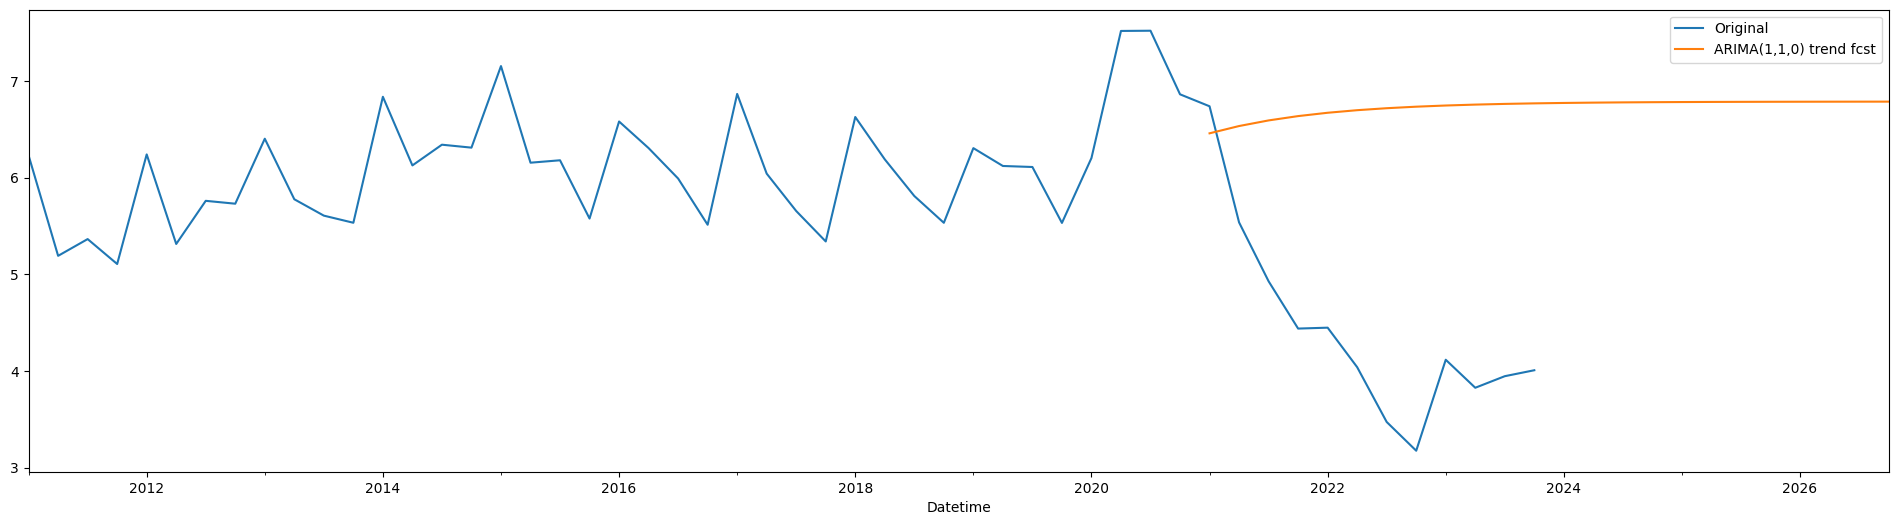

In [188]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df['Unemployment_Rate'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(1,1,0) trend fcst", ax=ax_arima_fcst)
plt.legend()

### 4.3.2 Adding seasonality back into forecasts

In [189]:
# Generate a list of monthly means in order
month_list = month_means.tolist()

# Calculate the number of repetitions needed to cover the predicted length
repeat_count = (len(arima_predictions) // len(month_list)) + 1

# Generate sufficiently long seasonal_values
seasonal_values = np.tile(month_list, repeat_count)[:len(arima_predictions)]

# Add the seasonal component back to the arima_predictions DataFrame
arima_predictions['seasonal'] = seasonal_values

# See Result
arima_predictions.head()

,trend,seasonal
2021-03-01,6.458580,0.554297
2021-06-01,6.533935,0.209582
2021-09-01,6.592012,0.056000
2021-12-01,6.636774,-0.361278
2022-03-01,6.671273,0.554297


In [190]:
arima_predictions['trend+seasonal'] = arima_predictions['trend'] + arima_predictions['seasonal']
arima_predictions.head()

,trend,seasonal,trend+seasonal
2021-03-01,6.458580,0.554297,7.012877
2021-06-01,6.533935,0.209582,6.743516
2021-09-01,6.592012,0.056000,6.648012
2021-12-01,6.636774,-0.361278,6.275496
2022-03-01,6.671273,0.554297,7.225570


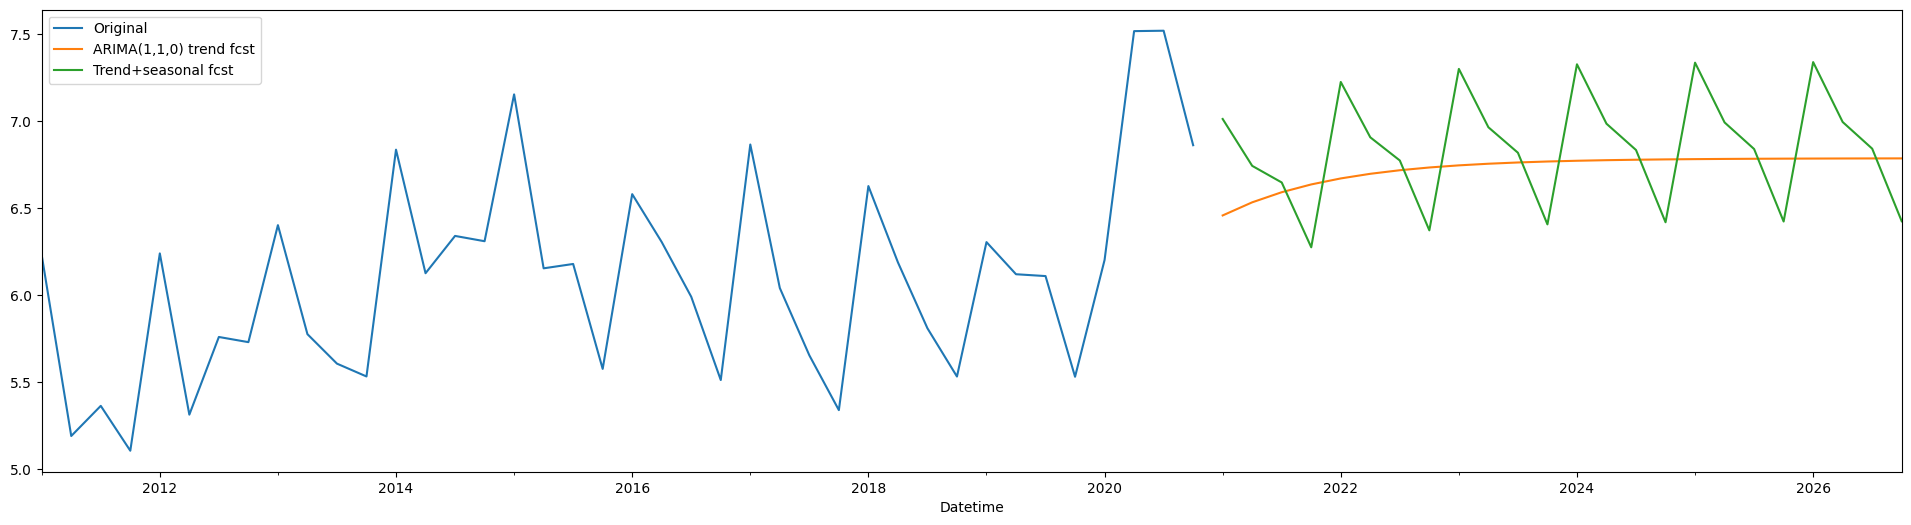

In [191]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
train['Unemployment_Rate'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(1,1,0) trend fcst", ax=ax_arima_fcst)
arima_predictions['trend+seasonal'].plot(label="Trend+seasonal fcst", ax=ax_arima_fcst)
plt.legend()

The ARIMA model captures the overall trend of the unemployment rate shown by orange line, and after adding seasonal factors, the forecast results are closer to the actual situation and show possible cyclical fluctuations by green line in the future. 

### 4.3.3 Plotting a confidence interval for the trend, based on the ARIMA model 

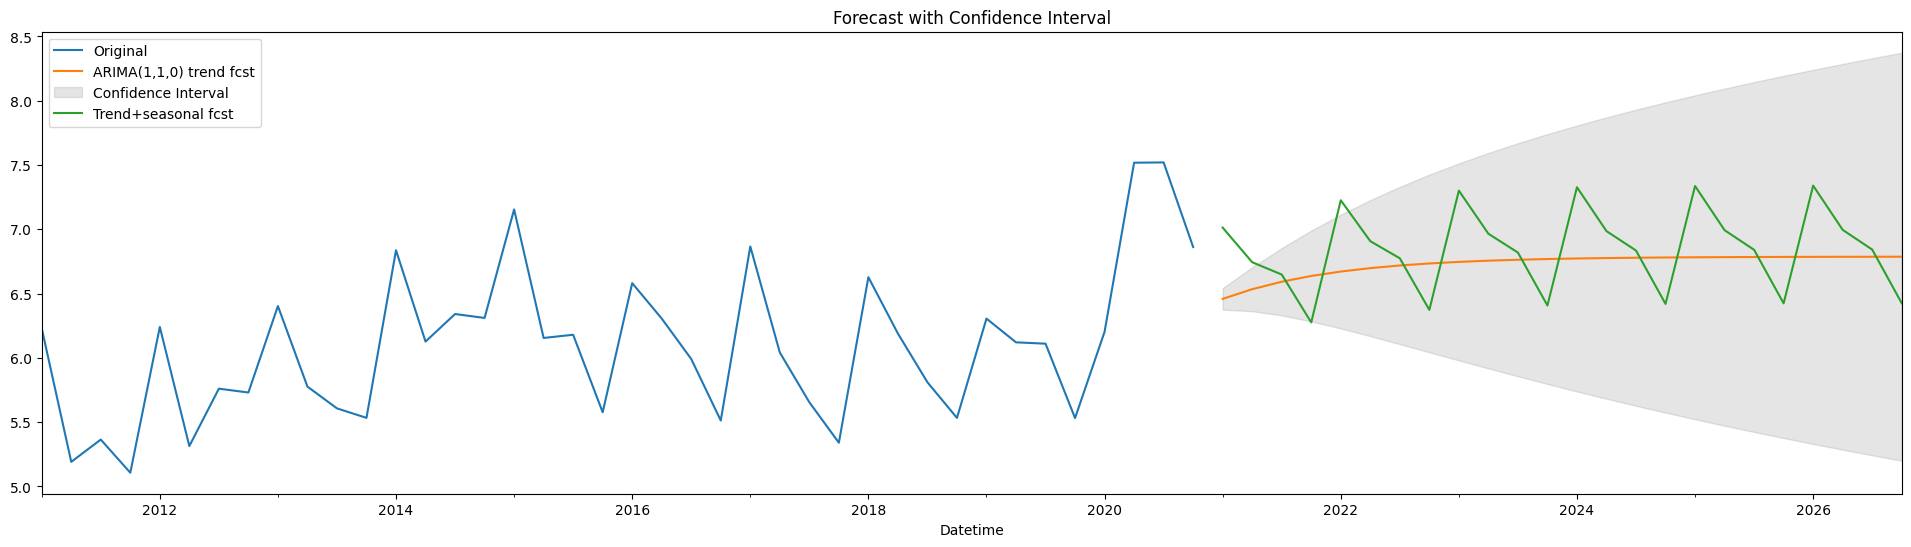

In [192]:
# Make forecasts using the ARIMA model and obtain confidence intervals
forecast = arima_1_1_0.get_forecast(steps=len(arima_predictions))
confidence_interval = forecast.conf_int()

# Extracting predicted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_values.index = arima_predictions.index
confidence_interval.index = arima_predictions.index
arima_predictions['trend lower CI'] = confidence_interval.iloc[:, 0]
arima_predictions['trend upper CI'] = confidence_interval.iloc[:, 1]

fig, ax_arima_fcst = plt.subplots(figsize=(24, 6))

# Original Unemployment Rate Data
train['Unemployment_Rate'].plot(label='Original', ax=ax_arima_fcst)

# Plot forecast trends and confidence intervals
forecast_values.plot(label="ARIMA(1,1,0) trend fcst", ax=ax_arima_fcst)
ax_arima_fcst.fill_between(forecast_values.index, 
                           arima_predictions['trend lower CI'], 
                           arima_predictions['trend upper CI'], 
                           color='gray', alpha=0.2, label="Confidence Interval")

# Plotting seasonal forecasts
arima_predictions['trend+seasonal'].plot(label="Trend+seasonal fcst", ax=ax_arima_fcst)

plt.title('Forecast with Confidence Interval')
plt.legend()
plt.show()


**Blue line (Original):**
Historical data representing Queensland's actual unemployment rate from 2011 to 2020. 

**Orange line (ARIMA(2,1,0) trend fcst):**
Trend prediction using the ARIMA(2,1,0) model. This model predicts future trends based on past data. This line is relatively smooth and reflects the long-term trend in the unemployment rate but does not account for seasonal fluctuations.

**Gray area (Confidence Interval):**
Represents the confidence interval (Confidence Interval) of the prediction result. The gray shaded area shows the range of uncertainty in the forecast results. This region gradually widens over future time periods, indicating that forecast uncertainty increases over time.

**Green line (Trend+seasonal fcst):**
This line represents the forecast result after adding seasonal factors based on the ARIMA forecast trend. Compared to pure trend forecasts, this line shows the unemployment rate forecast that includes cyclical changes, making the forecast closer to reality.

**Summarize:**
The figure shows the actual unemployment rate data, the forecast based on the ARIMA model, the improved forecast after adding seasonal factors, and the forecast confidence interval.
The expansion of the gray area in the figure shows the uncertainty when predicting the future, which is consistent with reality, because the longer the future, the greater the uncertainty.
Comparing different prediction results helps to evaluate the accuracy and robustness of the model, thereby deciding whether further adjustments to the model are needed to improve the credibility of the prediction.

In [193]:
confidence_interval.head()

,lower MA12 Trend,upper MA12 Trend
2021-03-01,6.374567,6.542593
2021-06-01,6.363087,6.704782
2021-09-01,6.329986,6.854039
2021-12-01,6.283377,6.990171
2022-03-01,6.228488,7.114057


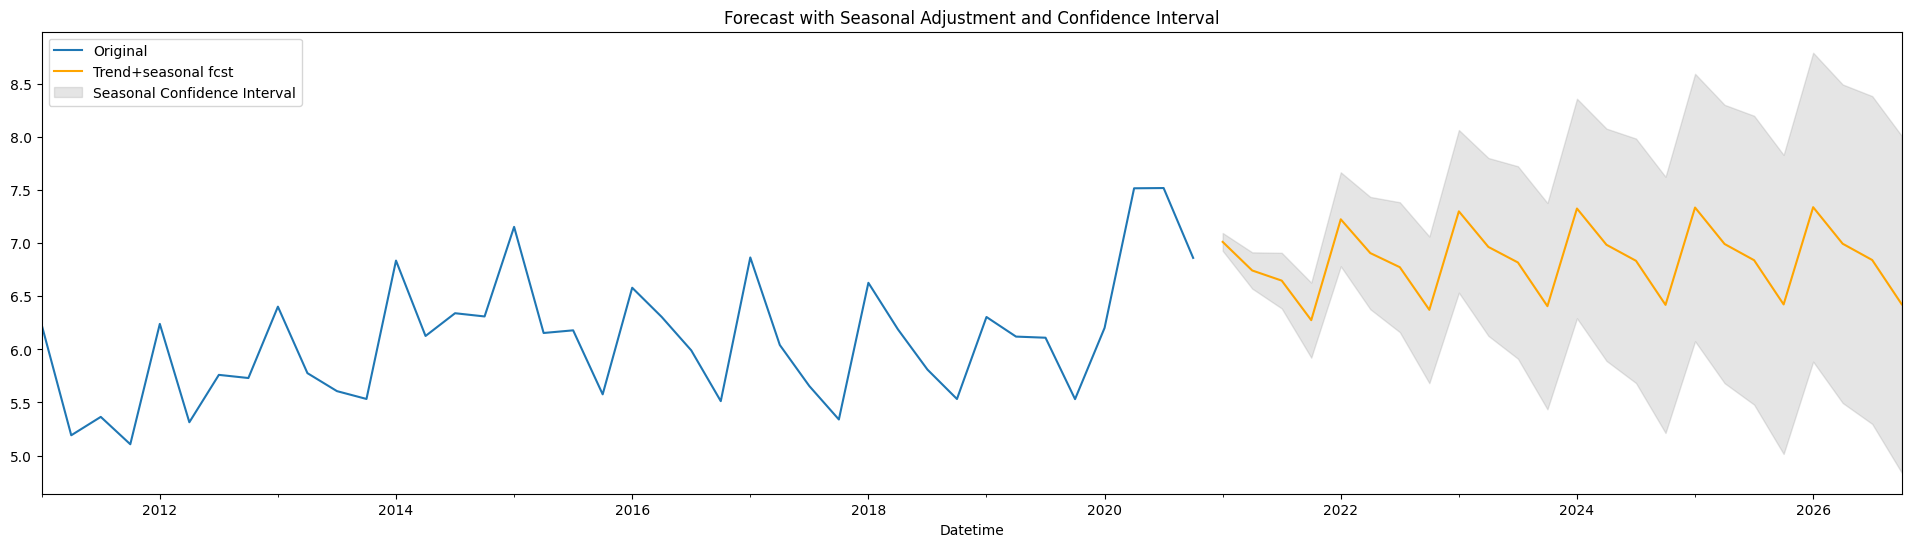

In [194]:
# Calculate the number of repetitions to cover the length of arima_predictions
repeat_count = (len(arima_predictions) // len(month_means)) + 1

# Generate sufficiently long seasonal factors
seasonal_values = np.tile(month_means, repeat_count)[:len(arima_predictions)]

# Make sure the length of seasonal_values matches the length of the DataFrame
arima_predictions['seasonal'] = seasonal_values

# Calculate seasonal forecast results and confidence intervals
arima_predictions['trend+seasonal'] = arima_predictions['trend'] + arima_predictions['seasonal']
arima_predictions['seasonal lower CI'] = arima_predictions['trend lower CI'] + arima_predictions['seasonal']
arima_predictions['seasonal upper CI'] = arima_predictions['trend upper CI'] + arima_predictions['seasonal']

# Plot
fig, ax_arima_fcst = plt.subplots(figsize=(24, 6))
train['Unemployment_Rate'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend+seasonal'].plot(label="Trend+seasonal fcst", ax=ax_arima_fcst, color='orange')
ax_arima_fcst.fill_between(arima_predictions.index, 
                           arima_predictions['seasonal lower CI'], 
                           arima_predictions['seasonal upper CI'], 
                           color='gray', alpha=0.2, label="Seasonal Confidence Interval")

plt.title('Forecast with Seasonal Adjustment and Confidence Interval')
plt.legend()
plt.show()

Taking seasonal factors into account, the forecast results and confidence intervals are more reasonable and comprehensive.

---

# 5. Pure Forcasters 

now consider choice of neural network-based methods:
- Select an appropriate **pure forecasting method** to **predict** the trend component of
the unemployment training data.
- Using the **seasonal component** that estimated in task 3b and the pure forecaster
from 5a, produce **forecasts** of Queensland unemployment for the test data series.
Include the uncertainty in the forecasts and visualise the predictions.

## 5.1 MLP Forecasting

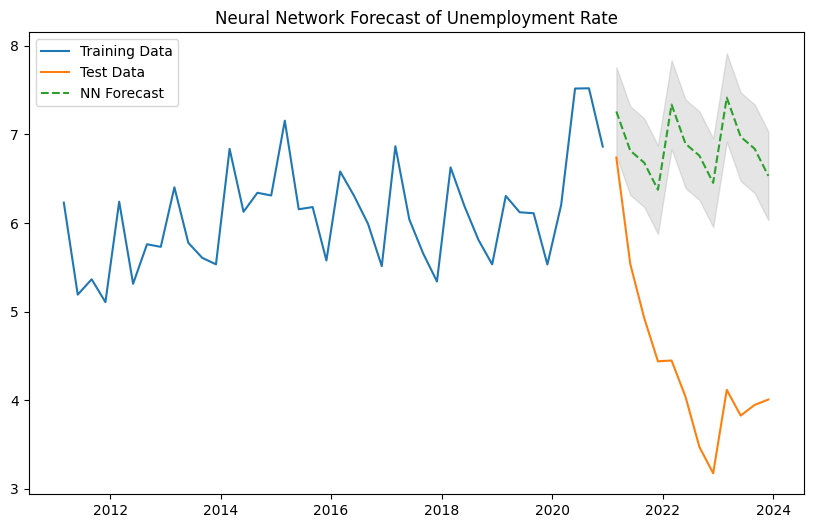

In [195]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

train = df['2011':'2020']['Unemployment_Rate']
test = df['2021':'2023']['Unemployment_Rate']

# Normalize the training and test data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

# Prepare input data (index of time series)
X_train = np.arange(len(train_scaled)).reshape(-1, 1)
y_train = train_scaled.ravel()

# Create and Train a Neural Network Model
nn_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)

# Make predictions on the test data
X_test = np.arange(len(train_scaled), len(train_scaled) + len(test)).reshape(-1, 1)
trend_nn_forecast_scaled = nn_model.predict(X_test)

# Denormalized prediction results
trend_nn_forecast = scaler.inverse_transform(trend_nn_forecast_scaled.reshape(-1, 1)).flatten()

# Perform STR decomposition
decomposition = sm.tsa.seasonal_decompose(train, model='additive', period=4)

# Repeating seasonal data
seasonal_values = decomposition.seasonal[-4:]  # Get the seasonal pattern of the last period
seasonal_values_repeated = np.tile(seasonal_values, len(trend_nn_forecast) // len(seasonal_values) + 1)[:len(trend_nn_forecast)]

# Combining trend and seasonal components
nn_forecast = trend_nn_forecast + seasonal_values_repeated

# Visualize Prediction
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, nn_forecast, label='NN Forecast', linestyle='--')
plt.fill_between(test.index, nn_forecast - 0.5, nn_forecast + 0.5, color='gray', alpha=0.2)  # Uncertainty
plt.title('Neural Network Forecast of Unemployment Rate')
plt.legend()
plt.show()

#### 1. Training Data:
- The blue line represents unemployment data from 2011 to 2020. The overall trend shows fluctuations and variations in unemployment rates over different years.
- There are clear cyclical patterns visible in the training data, with unemployment rates oscillating within a certain range over the quarters.

#### 2. Test Data:
- The orange line indicates the test data from 2021 to 2023. The test data shows a sharp decline in unemployment rates from 2021 to 2022, followed by a slight increase in 2023.
- This sharp decline may reflect the impact of certain policy adjustments or economic changes influencing the unemployment rate during this period.

#### 3. Neural Network Forecast:
- The green dashed line represents the neural network model’s forecast for the unemployment rate. The forecast exhibits cyclical fluctuations consistent with the previous observed patterns, indicating that the neural network model successfully captured the **seasonal behavior** of the unemployment rate.
- In the forecasted period (2021-2023), the predicted values oscillate around the actual test data, demonstrating a **periodic pattern**.

#### 4. Uncertainty Interval:
- The gray shaded area indicates the **uncertainty range** (confidence interval) of the forecast. As the timeline progresses, the uncertainty range expands, reflecting the inherent margin of error in the model’s predictions.
- The uncertainty band reasonably covers the forecasted values, indicating that the model accounts for potential variations in future predictions.

### Summary
- The chart demonstrates that the neural network model effectively captures the **cyclical variations** in the unemployment rate and provides reasonable forecasts during the test period.
- There is some deviation between the test data and the predicted values, but the overall trend aligns well, and the uncertainty band reasonably encompasses the forecasted range.
- **The model performs well**, showing relatively accurate forecasts for the test period, particularly in capturing the seasonal patterns.

### 5.1.2 Evaluate Prediction

In [196]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE
mae = mean_absolute_error(test, nn_forecast)
rmse = np.sqrt(mean_squared_error(test, nn_forecast))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 2.471919146770155
Root Mean Squared Error (RMSE): 2.6190916829815154


The Mean Absolute Error (MAE) of 2.4719 and the Root Mean Squared Error (RMSE) of 2.6191 indicate that the model's predictions have a substantial average deviation from the actual values. These values are relatively high, especially considering that unemployment rates typically do not have a very wide range. 

This suggests that the model's predictions are not very accurate, as it deviates by approximately 2.5 percentage points on average from the actual unemployment rate. The RMSE being slightly higher than the MAE shows that there are larger errors present as well, which may be influencing the model's performance. 

To improve accuracy, further tuning of the model, such as optimizing hyperparameters or incorporating additional features (e.g., external economic factors), might be necessary. Additionally, exploring different models like SARIMAX or LSTM, which might be better suited for time series forecasting, could provide more precise results.

## 5.2 Point Prediction

### 5.2.1 Data Preparation
Provides a high-level interface to the TensorFlow ML libraries.

In [197]:
# Create lagged data
df = df['Unemployment_Rate']
data = pd.concat([df,  
                 df.shift(),  
                 df.shift(2),
                 df.shift(3),
                 df.shift(4)], 
                 axis=1
                 ).dropna() 

In [198]:
data_np = np.array(data)

In [199]:
from sklearn.preprocessing import MinMaxScaler

# train test split, we can take last 1000 data points as test set
train, test = data_np[:41], data_np[41:]

# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# training data
y_train = train_scaled[:,0]
X_train = train_scaled[:,1:]

# test data
y_test = test_scaled[:,0]
X_test = test_scaled[:,1:]

### 5.2.2 Configure the neural networkz (Slff_Relu--only one hidden layer)

In [200]:
from tensorflow import keras

In [201]:
# Configure model
learning_rate = 0.001  # NN weight update rates

In [202]:
def slff_relu(input_dim,hidden_1_dim = 64):
    # Single-layer FF network with Rectified linear unit (relu) activation fxn
    inputs = keras.layers.Input(shape=(input_dim, ))
    hidden_layer_1 = keras.layers.Dense(hidden_1_dim, activation='relu')(inputs)
    outputs = keras.layers.Dense(1,activation='tanh')(hidden_layer_1)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [203]:
# typeout block below to prevent retraining
input_dim = 4 # equal to the number of lagged variables
model = slff_relu(input_dim)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

In [204]:
# Fit trains for 20 epochs with a batch size of 20, keeping the order of the time series intact
model.fit(X_train, y_train, epochs=20, batch_size=20, shuffle=False)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.22873
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1925  
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1639 
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1400  
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1203  
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1040  
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0909  
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0804  
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0720  
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0655 
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0604  
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0566
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0536  
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0513  
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0494  
Epoch 16/20
3/3 ━━━━━━━━

### 5.2.3 Time Series Point Prediction using Neural Networks

In [205]:
# Predict
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


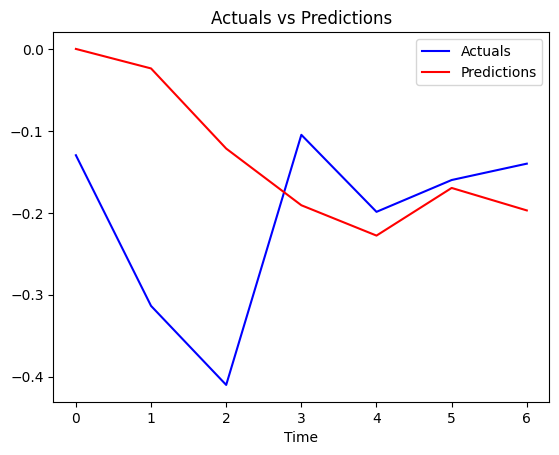

In [206]:
# Plot test data predictions
def plot_pred(y_test,y_pred,period=10):
    plt.figure()
    plt.plot(y_test[-period:], "b", label="Actuals")
    plt.plot(y_pred[-period:], "r", label="Predictions")
    plt.title("Actuals vs Predictions")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

plot_pred(y_test,y_pred)

### Compute and plot the test data errors to get a sense of the goodness of  these predictions

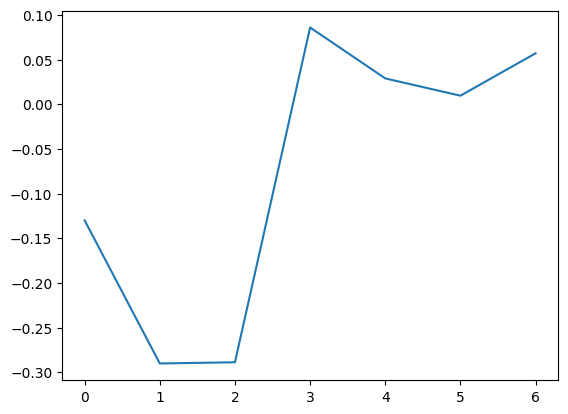

In [207]:
# Compute and plot the test data errors 
errors = np.squeeze(y_test) - np.squeeze(y_pred) 
plt.plot(errors)

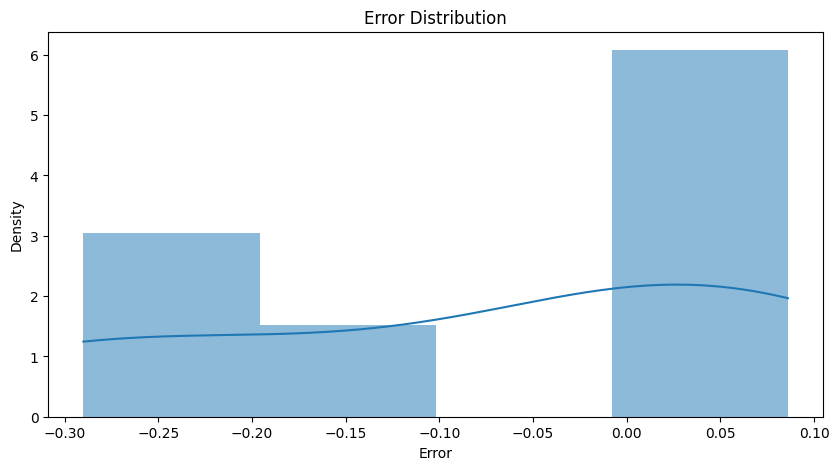

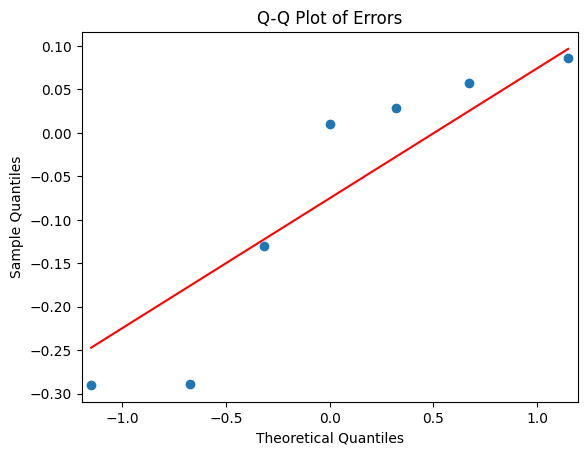

Shapiro-Wilk Test Statistic: 0.8363, p-value: 0.0918
Error is likely normally distributed (fail to reject H0).


In [208]:
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

# Draw the Error Histogram and KDE Curve
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, stat="density", linewidth=0)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Density')
plt.show()

# Draw a Q-Q plot to check if the errors are close to a normal distribution
qqplot(errors, line='s')
plt.title('Q-Q Plot of Errors')
plt.show()

# Use Shapiro-Wilk normality test
from scipy.stats import shapiro
stat, p_value = shapiro(errors)
print(f'Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}')
if p_value > 0.05:
    print("Error is likely normally distributed (fail to reject H0).")
else:
    print("Error is not normally distributed (reject H0).")

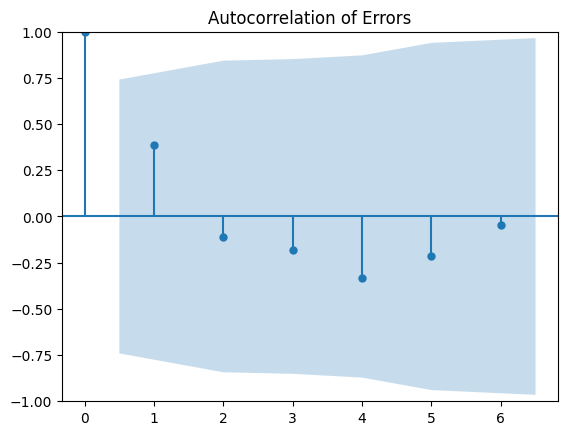

In [209]:
# Check if there is correlation between errors (autocorrelation test)
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function (ACF) of the error
plot_acf(errors, lags=6)
plt.title('Autocorrelation of Errors')
plt.show()

Based on the graphs and the Shapiro-Wilk test results, we can evaluate the quality of the forecast and the distribution of the errors. Here's an explanation of each plot, along with the interpretation of the test result:

#### 1. Error Plot：
   - This plot shows the errors, which are the differences between the actual values and the predicted values, over time.
   - Ideally, the errors should be randomly distributed and fluctuate around zero, indicating that the model predicts consistently across different time periods. In this plot, we observe some **fluctuations**, suggesting that the model's performance varies at certain time points.
   - Error Range: The error values indicates that the model's predictions are **relatively concentrated without large deviations**.
   - Density Shape: The density curve has a symmetric arch shape, suggesting the error values are mostly centered. This symmetry could indicate a near-normal distribution; however, the significant gap (white area) in the middle suggests missing values or gaps for specific error ranges.
   - Shaded Area: The shaded region in the background highlights where the probability of errors occurring is higher.

#### 2. Error Distribution Plot：
   - This plot displays a histogram of the errors along with a density estimation curve, showing the overall shape of the error distribution.
   - The errors appear to be **roughly symmetric**, which resembles a **normal distribution**. If the errors showed significant skewness or a bimodal shape, it would indicate model bias. In this case, the distribution appears reasonably centered around zero.

#### 3. Q-Q Plot:
   - The Q-Q plot is used to check whether the errors follow a normal distribution. The blue dots represent the actual error distribution, while the red line represents the ideal normal distribution.
   - If the blue dots align closely with the red line, it suggests that the errors are approximately normally distributed. In this plot, most of the points lie near the line, though a few deviate at the extremes, indicating that the errors are close to normal distribution with some **outliers**.

#### 4. Autocorrelation of Errors (ACF):
   - This plot shows the autocorrelation coefficients (ACF) of the errors, which helps identify if there is any time-related correlation in the errors. If the errors are independent, most of the points should fall within the blue confidence interval.
   - In this plot, most of the points are within the confidence interval, indicating that the **errors are not significantly autocorrelated**. This is a positive sign for the model as it shows that the errors are independent over time and there are **no systematic biases**.

#### 5. Shapiro-Wilk Test:
   - Since the p-value is greater than 0.05, we fail to reject the null hypothesis (H0) that the errors are normally distributed. This suggests that the errors likely **follow a normal distribution**, which is a **positive indication** of the model’s performance.

### Conclusion
- Combining the above graphs and the Shapiro-Wilk test result, we conclude that the model's forecast performance is **generally good**. The errors appear to be **approximately normally distributed**, and there is **no significant autocorrelation**. However, the error plot shows **some fluctuations at specific time points**, indicating that the model's accuracy varies at those periods, which may require further investigation.

## 5.3 Point Prediction -- Three Hidden Layers

In [210]:
# Configure model
learning_rate = 0.001  # NN weight update rates

In [211]:
def deepff(input_dim,hidden_1_dim = 64, hidden_2_dim = 32, hidden_3_dim = 32):
    inputs = keras.layers.Input(shape=(input_dim, ))
    hidden_layer_1 = keras.layers.Dense(hidden_1_dim, activation='relu')(inputs)
    hidden_layer_2 = keras.layers.Dense(hidden_2_dim, activation='tanh')(hidden_layer_1)
    hidden_layer_3 = keras.layers.Dense(hidden_3_dim, activation='relu')(hidden_layer_2)
    outputs = keras.layers.Dense(1, activation='tanh')(hidden_layer_3)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [212]:
# typeout block below to prevent retraining
input_dim = 4 # equal to the number of lagged variables
model = deepff(input_dim)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,489 (13.63 KB)

 Trainable params: 3,489 (13.63 KB)

 Non-trainable params: 0 (0.00 B)

In [213]:
# Fit trains for 20 epochs with a batch size of 20, keeping the order of the time series intact
model.fit(X_train, y_train, epochs=20, batch_size=20, shuffle=False)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3172  
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2315
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1765
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1342
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1042
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0836
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0695
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0599  
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0540
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0507 
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0492
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0485
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0481
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0480
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0477
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

In [214]:
# Predict
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


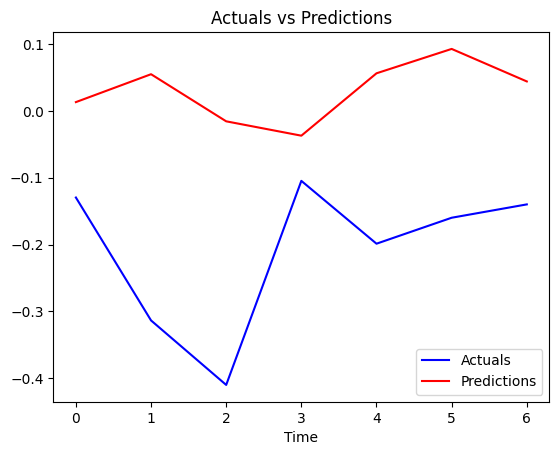

In [215]:
# Plot test data predictions
def plot_pred(y_test,y_pred,period=10):
    plt.figure()
    plt.plot(y_test[-period:], "b", label="Actuals")
    plt.plot(y_pred[-period:], "r", label="Predictions")
    plt.title("Actuals vs Predictions")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

plot_pred(y_test,y_pred)

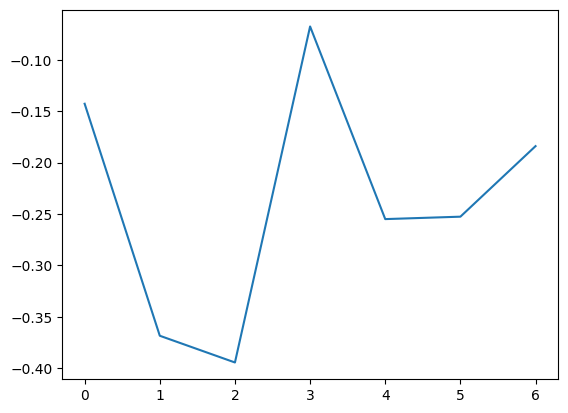

In [216]:
# Compute and plot the test data errors 
errors = np.squeeze(y_test) - np.squeeze(y_pred) 
plt.plot(errors)

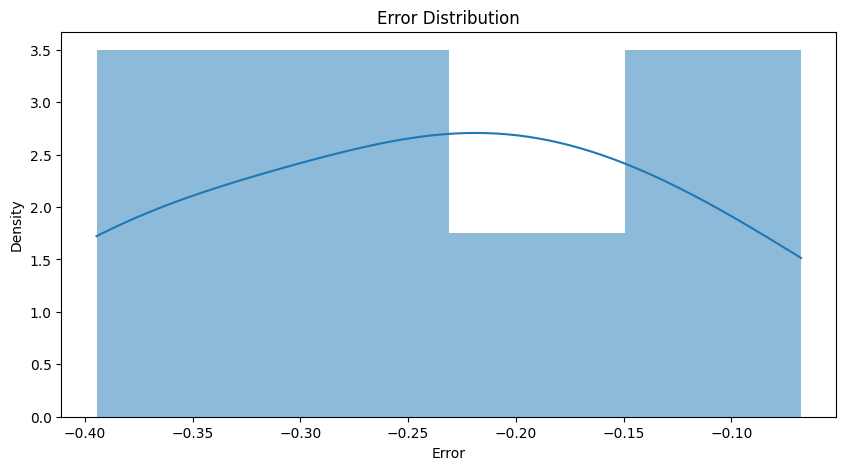

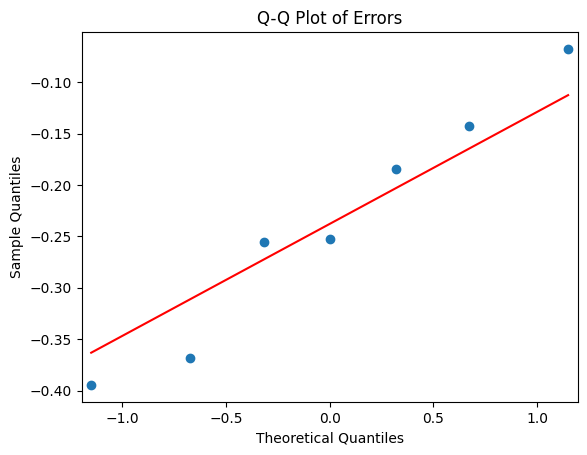

Shapiro-Wilk Test Statistic: 0.9584, p-value: 0.8046
Error is likely normally distributed (fail to reject H0).


In [217]:
# Draw the Error Histogram and KDE Curve
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, stat="density", linewidth=0)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Density')
plt.show()

# Draw a Q-Q plot to check if the errors are close to a normal distribution
qqplot(errors, line='s')
plt.title('Q-Q Plot of Errors')
plt.show()

# Use Shapiro-Wilk normality test
from scipy.stats import shapiro
stat, p_value = shapiro(errors)
print(f'Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}')
if p_value > 0.05:
    print("Error is likely normally distributed (fail to reject H0).")
else:
    print("Error is not normally distributed (reject H0).")

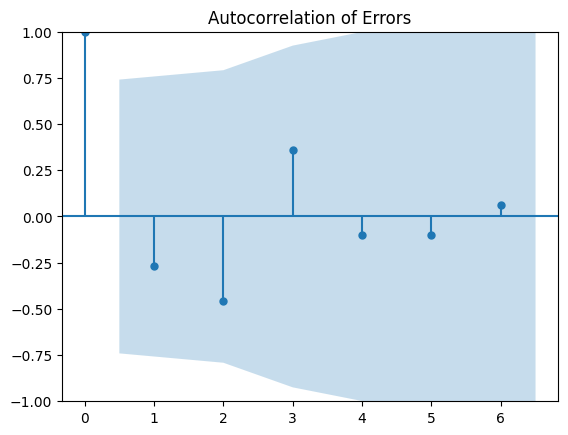

In [218]:
# Plot the autocorrelation function (ACF) of the error
plot_acf(errors, lags=6)
plt.title('Autocorrelation of Errors')
plt.show()

The **predictions generated by `deepff` are better** than those produced by `slff_relu`. The reason is that having three hidden layers allows `deepff` to extract more complex features and patterns, making it more suitable for handling non-linear and highly intricate data.

### `slff_relu` Function:
Since it only has a single hidden layer, its complexity is lower, and its expressive power is limited. This makes it suitable for simpler tasks or linearly separable data. Although the training process is faster and consumes fewer computational resources, a single-layer structure may struggle to learn and fit more complex patterns when the task is more demanding.
- Acutals vs Predictions Line Plot: The line are less pronounced, especially around the mid-points.The red line (predictions) does not align well with the blue line (actuals). There is a noticeable gap between the two, indicating that the model's **predictions consistently deviate from the actual values**.
- Test data errors line plot and Error Distribution Plot: **Higher diviations** between predictions and actuals. The distribution appears somewhat **symmetric** with a peak at the center and tails on both sides. The curve indicates a relatively balanced error distribution with higher densities concentrated around the mid-range errors.
- Q-Q Plot of Erros: The points are closer to the red line, indicating that the errors are more normally distributed. **Deviations** from the line are **minimal**, suggesting a good fit to the theoretical quantiles. Model's errors are well-behaved and consistent with a normal distribution.
- Autocorrelation of Errors: The autocorrelation values for most lags fall within the confidence interval, indicating little to no significant autocorrelation.A few points (especially at lag 1 and 2) slightly dip below the lower bound, suggesting minimal negative autocorrelation. The error terms are mostly **independent**.

### `deepff` Function:
With its multi-layer structure, the network has greater expressive power and learning capacity, enabling it to fit complex data distributions effectively. However, this also makes it more prone to overfitting, requiring more training data and stronger regularization techniques to prevent this issue.
- Acutals vs Predictions Line Plot:The fluctuations **fluctuates more prominently** compared to the slff_relu. The red line still shows deviation from the blue line, but it captures the trend more accurately. The fluctuations in the actual values are better represented by the predictions.
- Test data errors line plot and Error Distribution Plot: The **error values are smaller**. This suggests that the model's predictions are closer to the actual values, resulting in reduced errors. The distribution is skewed to the right, with a larger concentration of errors at the beginning and a long tail extending to the right. The right-skewed pattern suggests that most errors are concentrated in a smaller range, and there are fewer instances of larger errors.
- Q-Q Plot of Erros: There are some **noticeable deviations**, especially towards the ends of the distribution. The overall alignment is less consistent compared to the left plot.
- Autocorrelation of Errors: The pattern is very similar to the left plot, with most autocorrelation values remaining within the confidence interval. However, there is a point at lag 3 that rises close to the upper bound, indicating a slight positive autocorrelation at this lag. Despite this, the error terms generally appear to be **independent**, as the majority of values are within bounds.

### Summary
The deepff model is better because it captures the trend more accurately and has a smaller error, which is usually more important in predictive modeling. The slff_relu model, while more consistent in its error behavior, has a larger prediction bias.

##  5.4 Multistep point prediction
The multistep prediction loop include an optional residuals input, which is used later for bootstrapping.

In [219]:
def multistep_prediction(H, model, X_pred,residuals=[]):
    # Initialise lists for storing multi-step predictions
    y_pred_multi = []
    X_pred_multi = []

    for t in range(H):
        # get next prediction
        X_pred = np.array(X_pred.reshape(1,len(X_pred)))
        new_y= float(model.predict(X_pred))
        # print("new_y")
        # print(new_y)
    
        # update 
        y_pred_multi.append(float(new_y))
        X_pred_multi.append(list(X_pred[0])) 
        # print("y_pred_multi")
        # print(y_pred_multi)
        # print("X_pred_multi")
        # print(X_pred_multi)
    
        # prepare net input with bootstrapped training residuals
        X_pred = X_pred_multi[t][:-1]
        if len(residuals) == 0:
            X_pred.insert(0,new_y)
        else:
            X_pred.insert(0,(new_y+np.random.choice(residuals)))
        X_pred = np.array(X_pred)
        # print("new X")
        # print(X_pred)
        
    return y_pred_multi, X_pred_multi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/tmp/ipykernel_642737/1236218818.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_y= float(model.predict(X_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


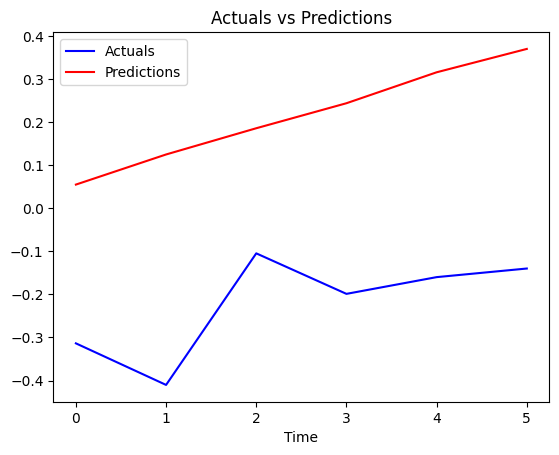

In [220]:
# Prediction horizon
H = 6 

X_test_multi = X_test[-H:,:]
y_test_multi = y_test[-H:]
# y_pred_multi = model.predict(X_test_multi)    
# plot_pred(y_test_multi,y_pred_multi)

# Prepare first input to multistep prediction loop
X_pred = X_test_multi[0,:]

# Multistep prediction
y_pred_multi, X_pred_multi = multistep_prediction(H,model,X_pred)
plot_pred(y_test_multi, y_pred_multi)

## 5.5 Bootstrapping for Interval Predictions using Neural Networks

In [221]:
# Calculate the training data residuals
residuals = np.squeeze(y_train) - np.squeeze(model.predict(X_train))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


### 5.5.1 Boostrapping errors to generate forecast distributions

In [222]:
# Bootstrap iterations
K = 100 

# Prepare first input to multistep bootsrtap loop
X_pred = X_test_multi[0,:]
y_pred_bootstrap = []

# Use multistep prediction to generate bootstrap data, 
# List of training residuals to sample from passed in as fourth argument 

for k in range(K):
    y_pred_multi, X_pred_multi = multistep_prediction(H,model,X_pred,residuals)
    y_pred_bootstrap.append(y_pred_multi)
    # store y predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/tmp/ipykernel_642737/1236218818.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_y= float(model.predict(X_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

### 5.5.2 Visualize bootstrapped interval forecasts

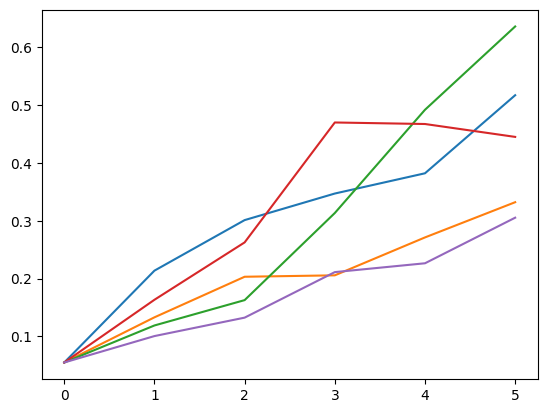

In [223]:
# Useful utility method for transposing lists of lists    
def transposed_2d_list(l):
    return [[row[i] for row in l] for i in range(len(l[0]))]    

plt.plot(transposed_2d_list(y_pred_bootstrap[-5:]))

In [224]:
bootstrap_predictions = pd.DataFrame(index = data.index.values[-H:])

for pctl in range(0,101,10):
    bootstrap_predictions[str(pctl)] = np.percentile(y_pred_bootstrap,pctl,axis=0)

bootstrap_predictions.rename(columns={'50': "median"}, inplace=True)
bootstrap_predictions['actuals'] = y_test[-H:]

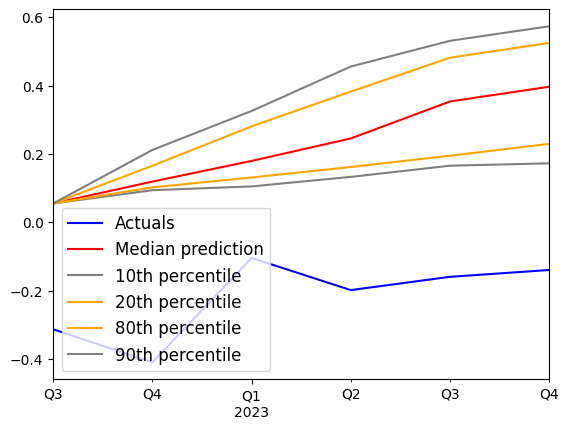

In [225]:
# illustrate the uncertainty with percentiles
fig, ax_bootstrap_2 = plt.subplots()
bootstrap_predictions['actuals'].plot(color = 'blue', label='Actuals')
bootstrap_predictions['median'].plot(color = 'red',label = 'Median prediction' )
bootstrap_predictions['10'].plot(color = 'grey',label = '10th percentile')
bootstrap_predictions['20'].plot(color = 'orange',label = '20th percentile' )
bootstrap_predictions['80'].plot(color = 'orange',label = '80th percentile' )
bootstrap_predictions['90'].plot(color = 'grey',label = '90th percentile')
plt.legend(loc = 'lower left', fontsize = 12)

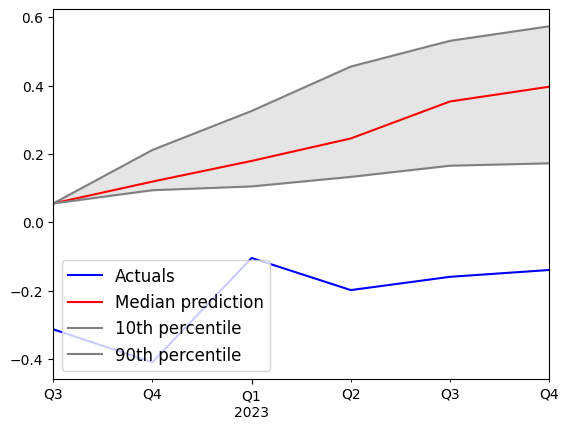

In [226]:
# plot interval with fill(shaded area)
fig, ax_bootstrap = plt.subplots()
bootstrap_predictions['actuals'].plot(color = 'blue', label='Actuals')
bootstrap_predictions['median'].plot(color = 'red',label = 'Median prediction')
bootstrap_predictions['10'].plot(color = 'grey', label = '10th percentile' )
bootstrap_predictions['90'].plot(color = 'grey', label = '90th percentile')
plt.legend(loc = 'lower left', fontsize = 12)

x = data.index.values[-H:]
plt.fill_between(x, bootstrap_predictions['10'], bootstrap_predictions['90'], color='grey', alpha=0.2)

In [227]:
from sklearn.metrics import mean_pinball_loss as mpl
mpl(bootstrap_predictions['actuals'],bootstrap_predictions['median'], alpha=0.5) 

0.22298032836978285

Mean_pinball_loss represents the average deviation between the predicted median and the actual value. This value is acceptable.

In [228]:
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.2378978697151989
Root Mean Squared Error (RMSE): 0.2616496483878741


- MAE (Mean Absolute Error): indicates that, on average, the model's predictions are off by approximately 0.24 units from the actual values.
- RMSE (Root Mean Squared Error): suggests that the squared deviations from the actual values are larger, and the overall error is relatively consistent.

The error values indicate that while the predictions are close to the actuals, there is still a moderate level of deviation. The interval predictions capture the true trend fairly well, showing some robustness in the forecast.

However, there might happen unpredictable events, which influence QLD unemployment rate after 2020.

----

# 6. Using Side Data

how might different interest rate projections affect the forecasts?
- Specifically, generate a series of values corresponding to a **hypothetical reduction of
interest rates by 0.5%** for the **next six months** beyond the end of the test data, and a
second series of values corresponding to interest rates remaining at their current
level for the same duration.
- Use each projection of the **side information** to generate **two forecasts of the
unemployment timeseries** for **six months** beyond the end of the test data. Use any
model, e.g. ARIMAX or neural network.
- **Visualise** the two forecasts, including uncertainties in them
- Discuss the **difference** between the two timeseries predictions.

In [229]:
df = combine_quarterly_data(merged_df)
df.index = df.index.to_timestamp()
train = df['2011':'2020']
test = df['2021':]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53413D-01    |proj g|=  1.37669D+00

At iterate    5    f=  3.69090D-01    |proj g|=  2.16405D-01

At iterate   10    f=  3.29266D-01    |proj g|=  1.32627D-02

At iterate   15    f=  3.28667D-01    |proj g|=  9.32469D-02

At iterate   20    f=  3.25230D-01    |proj g|=  1.51679D-01

At iterate   25    f=  3.23705D-01    |proj g|=  5.88421D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     43      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  4.90587D-01    |proj g|=  2.62370D-03

At iterate   10    f=  4.90566D-01    |proj g|=  2.52583D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   2.526D-06   4.906D-01
  F =  0.49056645816467875     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


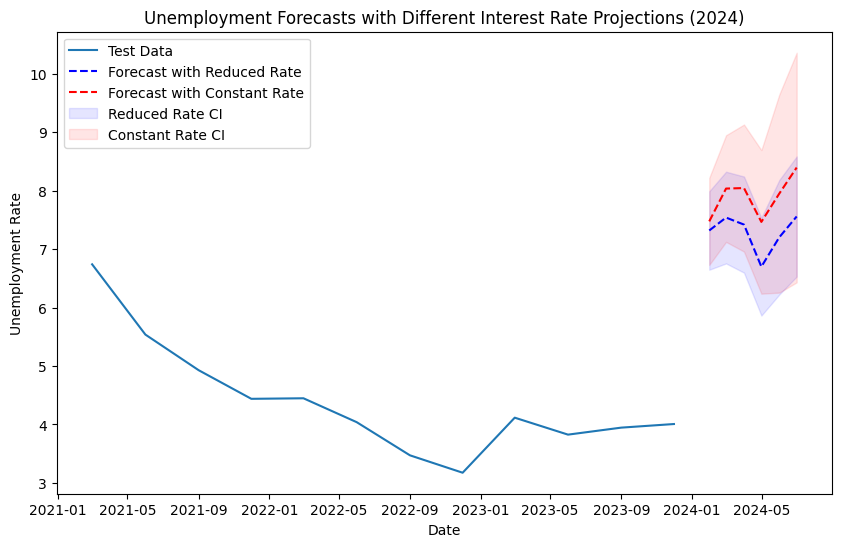

In [230]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

unemployment_rate_series = train['Unemployment_Rate']

# Ensure that the time index of interest_rate_df is aligned with train and fill missing values
aligned_interest_rate = interest_rate_df.reindex(train.index).ffill().astype(float)

# Assume a 0.5% interest rate cut scenario
reduced_rate_value = aligned_interest_rate.iloc[-1] - 0.5 / 100
reduced_rate_series = np.array([reduced_rate_value] * 6).reshape(-1, 1)

# Assume constant interest rate scenario
constant_rate_value = aligned_interest_rate.iloc[-1]
constant_rate_series = np.array([constant_rate_value] * 6).reshape(-1, 1)

# Make sure aligned_interest_rate is aligned with the index of unemployment_rate_series
aligned_interest_rate = aligned_interest_rate.reindex(unemployment_rate_series.index).ffill().values.reshape(-1, 1)

# Using the ARIMAX model (assuming seasonality and external interest rate data)
arimax_model_reduced = SARIMAX(unemployment_rate_series, exog=aligned_interest_rate, order=(1, 0, 0), seasonal_order=(1, 1, 1, 4))
arimax_result_reduced = arimax_model_reduced.fit()
forecast_reduced = arimax_result_reduced.get_forecast(steps=6, exog=reduced_rate_series)

arimax_model_constant = SARIMAX(unemployment_rate_series, exog=aligned_interest_rate, order=(1, 1, 0), seasonal_order=(1, 0, 0, 4))
arimax_result_constant = arimax_model_constant.fit()
forecast_constant = arimax_result_constant.get_forecast(steps=6, exog=constant_rate_series)

# Generate a future date, 6 months from the end of 2023
last_date = pd.Timestamp('2023-12-31')
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='ME')

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(test['Unemployment_Rate'], label='Test Data')
plt.plot(future_dates, forecast_reduced.predicted_mean, label='Forecast with Reduced Rate', linestyle='--', color='blue')
plt.plot(future_dates, forecast_constant.predicted_mean, label='Forecast with Constant Rate', linestyle='--', color='red')

# Draw confindence interval
plt.fill_between(future_dates, 
                 forecast_reduced.conf_int().iloc[:, 0], 
                 forecast_reduced.conf_int().iloc[:, 1], 
                 color='blue', alpha=0.1, label='Reduced Rate CI')
plt.fill_between(future_dates, 
                 forecast_constant.conf_int().iloc[:, 0], 
                 forecast_constant.conf_int().iloc[:, 1], 
                 color='red', alpha=0.1, label='Constant Rate CI')

plt.title('Unemployment Forecasts with Different Interest Rate Projections (2024)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()


# This chart illustrates unemployment rate forecasts under different interest rate scenarios:

#### 1. Test Data (Blue solid line):
   - The test data shows the actual unemployment rate trend from early 2021 to the end of 2023. It indicates a decline in the unemployment rate from the high point at the beginning of 2021, stabilizing throughout 2022 and 2023.

#### 2. Two Forecast Scenarios:
   - **Orange Dashed Line** ("Forecast with Reduced Rate"): This line represents the forecast assuming a 0.5% reduction in the interest rate for the next six months. The line shows a slight decrease in the unemployment rate under this scenario over the upcoming months.
   - **Green Dashed Line** ("Forecast with Constant Rate"): This line represents the forecast assuming the interest rate remains constant for the next six months. The forecast indicates a relatively stable unemployment rate with slight fluctuations.

#### 3. Confidence Intervals (CI):
   - **Blue Shaded Area**: This CI corresponds to the "Forecast with Reduced Rate" scenario. It shows the range of uncertainty around the forecast values. The interval widens as time progresses, indicating an increase in uncertainty in the forecast further into the future.
   - **Pink Shaded Area**: This CI corresponds to the "Forecast with Constant Rate" scenario. Similar to the blue area, the pink CI expands over time, demonstrating the increasing uncertainty of the model’s predictions as it forecasts further out.

### Summary
The two scenarios show different forecast trajectories. 
- The scenario with the reduced interest rate (orange line) suggests a **potential further decline** in the unemployment rate.
- With a constant interest rate, the green line indicates that the unemployment rate will **remain relatively stable** with minor variations.
- Reduced interest rate might bring the decline in the unemployment rate.
- The widening confidence intervals for both scenarios reveal that uncertainty increases as the forecast extends further into the future, making predictions less precise over time.